# Experimental 4D-STEM Data Processing: Large FOV $\text{MoS}_2-\text{MoSe}_2$ Lateral Heterojunction Superlattice

In [4]:
# Import the python script containing the helper functions and classes
from fourdenoise import *
plt.rcParams['font.family'] = 'Arial'

## 1. Data Loading and Preprocessing

### 1.1. Load and Visualize Raw 4D-STEM Data

Load your dataset using `HyperData(<<your_filepath_here>>)`

In [5]:
filepath = "./mini_dataset_binned.npy"

# Instantiate as a 4Denoise HyperData object
superlattice_data = HyperData(filepath)

We start by finding the electron dose over the dataset according to the acquired intensities on the diffraction patterns

In [6]:
# Conversion to electron-hit events per real-space scan position (pixel)
tot_sum = superlattice_data.array.sum(axis=(2,3))

In [8]:
mean_e_hits = np.mean(tot_sum)/151 # The '151' comes from the EMPAD detector,  a conversion factor into number of electrons
mag = 75 # 75000X magnification
conversion_factor = 0.46*840/mag # nm/px
unit_conversion = 10 # Å/nm
# area_per_pixel = (conversion_factor*unit_conversion)**2 # Å^2
area_per_pixel = np.pi*(14.054)**2/4 # FWHM based on convergence angle
electron_dose = mean_e_hits/area_per_pixel # e/Å^2

print(rf"The electron dose for this dataset is approximately {electron_dose} e/Å^2")

The electron dose for this dataset is approximately 165.9284597383003 e/Å^2


Make a HAADF detector and see the resulting virtual image

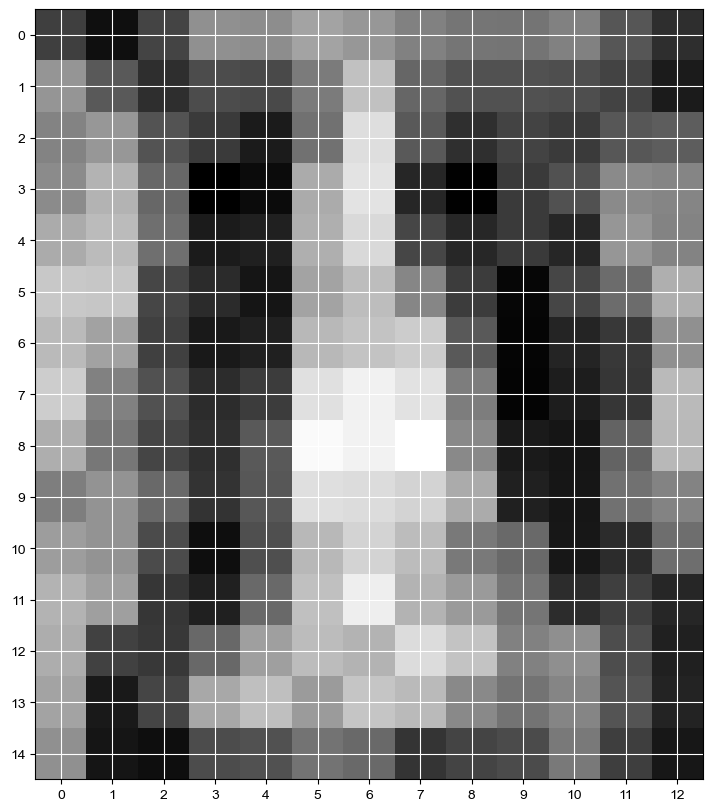

C:\Users\haloe\Documents\CodeWriting\4Denoise\helpers\fourdenoise.py:2936: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.mean(self.array, axis=(0,1))*detector_mask), cmap='turbo',)


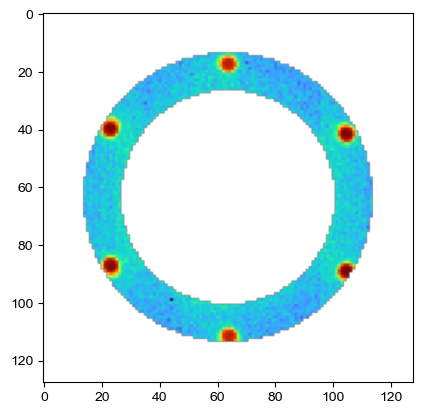

In [9]:
rmin = 37
rmax = 50

plt.figure(figsize=(10,10))
haadf = superlattice_data.get_virtualImage(rmin, rmax, plotMask=True, axes=True, gridColor='white')

### 1.2. Align Diffraction Patterns in 4D-STEM Data

We employ the `alignment` method available through the `HyperData` object. Note the improvement in precision of the center beam locations and the minimization of the center-beam's variation in position.

In [10]:
superlattice_data = superlattice_data.alignment(r_center=8, iterations=1)

Computing centers of mass: 100%|██████████████████████████████████████████████████████| 15/15 [00:00<00:00, 823.80it/s]


Initial standard deviation statistics (ky, kx): (0.0625, 0.0748)
Initial COM (ky, kx): (63.6613, 64.4671)

Processing 15 × 13 real-space positions. Iteration (1/1)...


Computing centers of mass: 100%|██████████████████████████████████████████████████████| 15/15 [00:00<00:00, 594.09it/s]

Standard deviation statistics (ky, kx): (0.0009, 0.0011)
COM (ky, kx): (63.5006, 63.5031)


### 1.3. Fix Global Elliptical Distortions

We employ the `fix_elliptical_distortions` method available through the `HyperData` object. This method fits and ellipse over an annular region and determines the necessary transformations that have to be made to the diffraction patterns to result in a more circular diffraction. Note how the ellipses' axis measurements 'a' and 'b' become more similar, hence less visible/quantifiable ellipticity.

In [11]:
# Whe choose the inner and outer rings so that they encompass the second-order peaks, as they are of great brightness
# TIP: Use `superlattice_data.get_virtualImage(r, R, plotMask=True,)` to see the annular mask drawn overlapped over mean diffraction pattern

r = 43.5
R= 51.5

superlattice_data = superlattice_data.fix_elliptical_distortions(r=43.5, R=51.5, return_fix=True)

Ellptical statistics before correction:
Ellipse rotation = 41.229787224828634 degrees 
Major axis 'a' = 47.8380660227989 px 
Minor axis 'b' = 46.62208916310692 px 



Fixing elliptical distortions: 100%|██████████████████████████████████████████████████| 15/15 [00:00<00:00, 181.95it/s]

Ellptical statistics after correction:
Ellipse rotation = 127.84870819220298 degrees 
Major axis 'a' = 47.84527524390976 px 
Minor axis 'b' = 47.8302697477653 px 



In [472]:
np.save('./superlattice_data_processed.npy', superlattice_data.array)

## 2. Data Processing: Peak-finding and Intensity Integration

### 2.1. Find Bragg peaks for a reference diffraction pattern (from a flat region)

In [12]:
superlattice_data.get_dp?

Signature:
superlattice_data.get_dp(
    y=None,
    x=None,
    real_mask=None,
    reciprocal_mask=None,
    **flat_kwargs,
)
Docstring:
Obtain a diffraction pattern from a specific 4D dataset, either at a 
specific point, averaged over a specified region, or a special diffraction
such as the dataset's 'mean', 'median', 'max', etc..

Inputs:
    y: (tuple of int, int, or string) If tuple (ymin, ymax), it 
       specifies the vertical coordinate range to average over. If int,
       it specifies a specific vertical coordinate. If string, 'y' must 
       be one of the operations in 'operations' and returns the corresponding
       special diffraction pattern such as the 'mean', 'median', etc.
    x: (tuple of int or int, optional) If tuple (xmin, xmax), it 
       specifies the horizontal coordinate range to average over. If 
       int, it specifies a specific horizontal coordinate.

Returns: 
    dp: (numpy array) Diffraction pattern, either at a specific point, 
    averaged over 

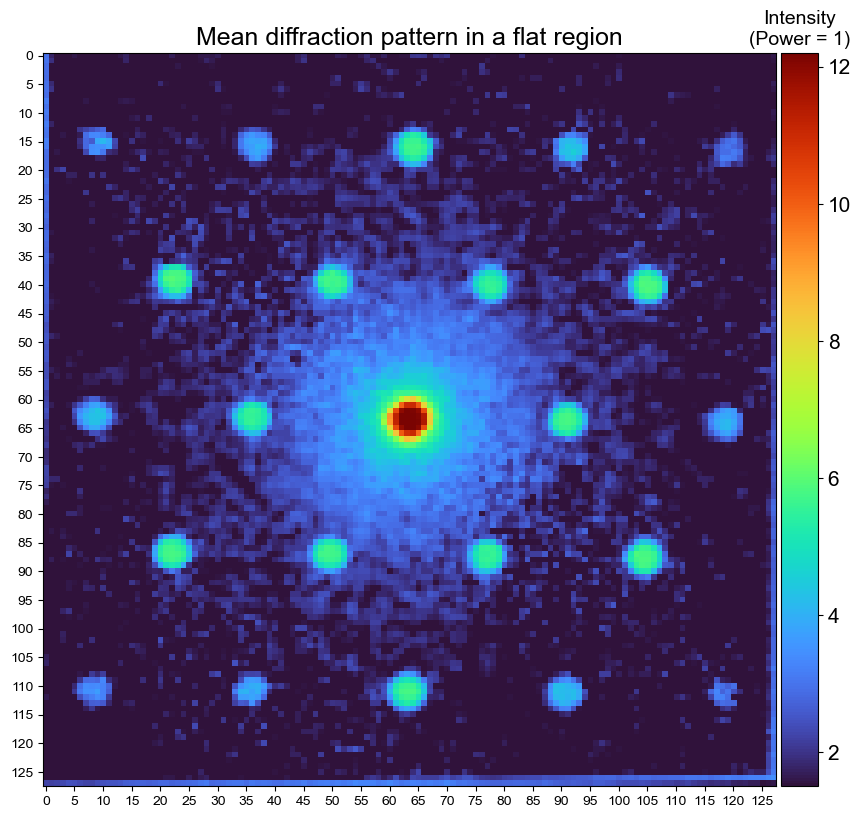

In [13]:
# Note that (125, 133) are the pixel coordinates of a flat region based on the HAADF images acquired above
flat_dp = superlattice_data.get_dp(y=(2,11), x=(6)) 
flat_dp.show(vmin=1.5, title="Mean diffraction pattern in a flat region")

We find the reference Bragg peak positions using one of two options (more methods available in **4Denoise** but not implemented in this notebook)

#### Option 1: Using `find_peaks' (parameter tuning required)

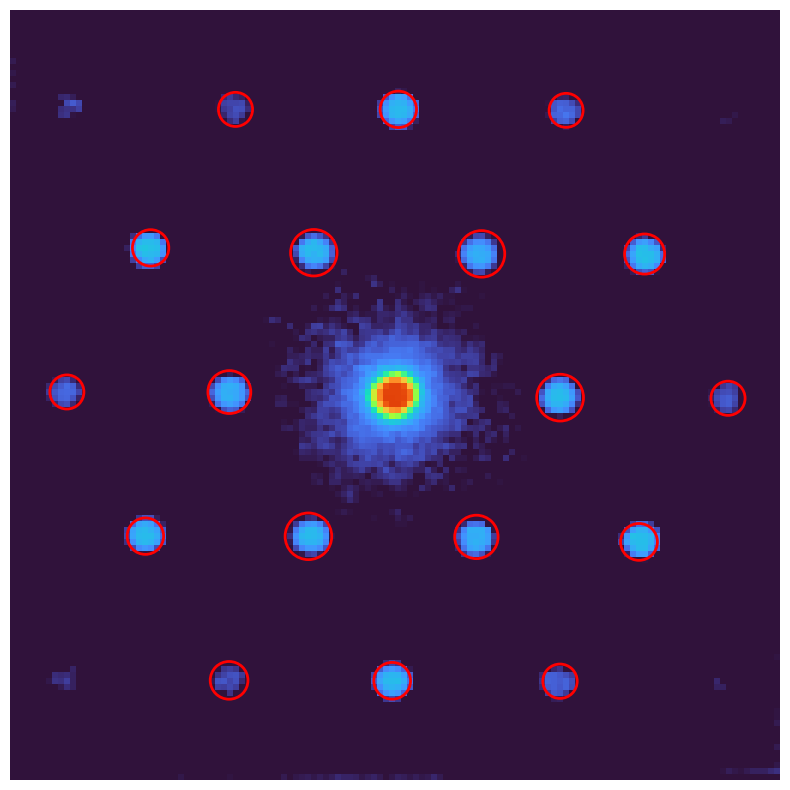

In [20]:
ref_coords, radii = flat_dp.find_peaks(
                       min_sigma=1.3, # Smallest radius for the Bragg peaks searched for
                       max_sigma=5, # Largest radius for the Bragg peaks searched for
                       num_sigma=20, # How many radius values to search for in the range [min_sigma, max_sigma]
                       threshold=1.5, # The absolute lower bound of integrated intensity within spot
                       mask_radial_frac=(0.2, 1.1), # Radial region in which spots are searched for
                       distance_factors=(0.7, 2), # Relative allowed distance between neighboring Peaks (1 = mean distance)
                       search_radius_factor=1, # Enlarge radius to find Bragg peak center/maxima
                       radii_multiplier=1.5, # Parameter for adjusting radii for background subtraction purposes
                       radii_slope=1.5,      # Parameter for adjusting radii for background subtraction purposes
                       vmin=3, vmax=14, # The limits of the plot in logscale
                       axes=False, 
                       plotCenters=True, # Whether or not to visualize the found peaks (recommended 'True')
                       power=0.5, # Raise the values in diffraction pattern to this power to shorten peak heights
                       return_radii=True, # Return an array with the approximate radius for each spot 
                       order_length=6, # Optionally sorts peaks, for each order, based on their angular position
                       method='CoM',                       
)

In [21]:
ref_coords

array([[ 39.8491258 ,  50.00599167],
       [ 63.01206609,  35.96505704],
       [ 86.98842299,  49.10743946],
       [ 87.09394203,  77.03118322],
       [ 63.9382031 ,  90.94452402],
       [ 40.04159683,  77.87616832],
       [ 39.04394488,  22.87666601],
       [ 86.96168958,  22.00523928],
       [111.00705759,  63.03306817],
       [ 87.92151459, 104.05689504],
       [ 40.06628519, 104.99556211],
       [ 16.0158382 ,  64.04948087],
       [ 16.02348005,  36.98621467],
       [ 62.99753748,   8.95445336],
       [110.93495949,  35.9211056 ],
       [111.08111295,  90.93103202],
       [ 64.04356431, 118.85554293],
       [ 16.18031574,  91.94198135]])

#### Option 2: Using `select_peaks' (manual option)

**Note:** This method might fail to load. This will be fixed in a latter version of 4Denoise. 

The image below shows an example of the pop-up interactive figure

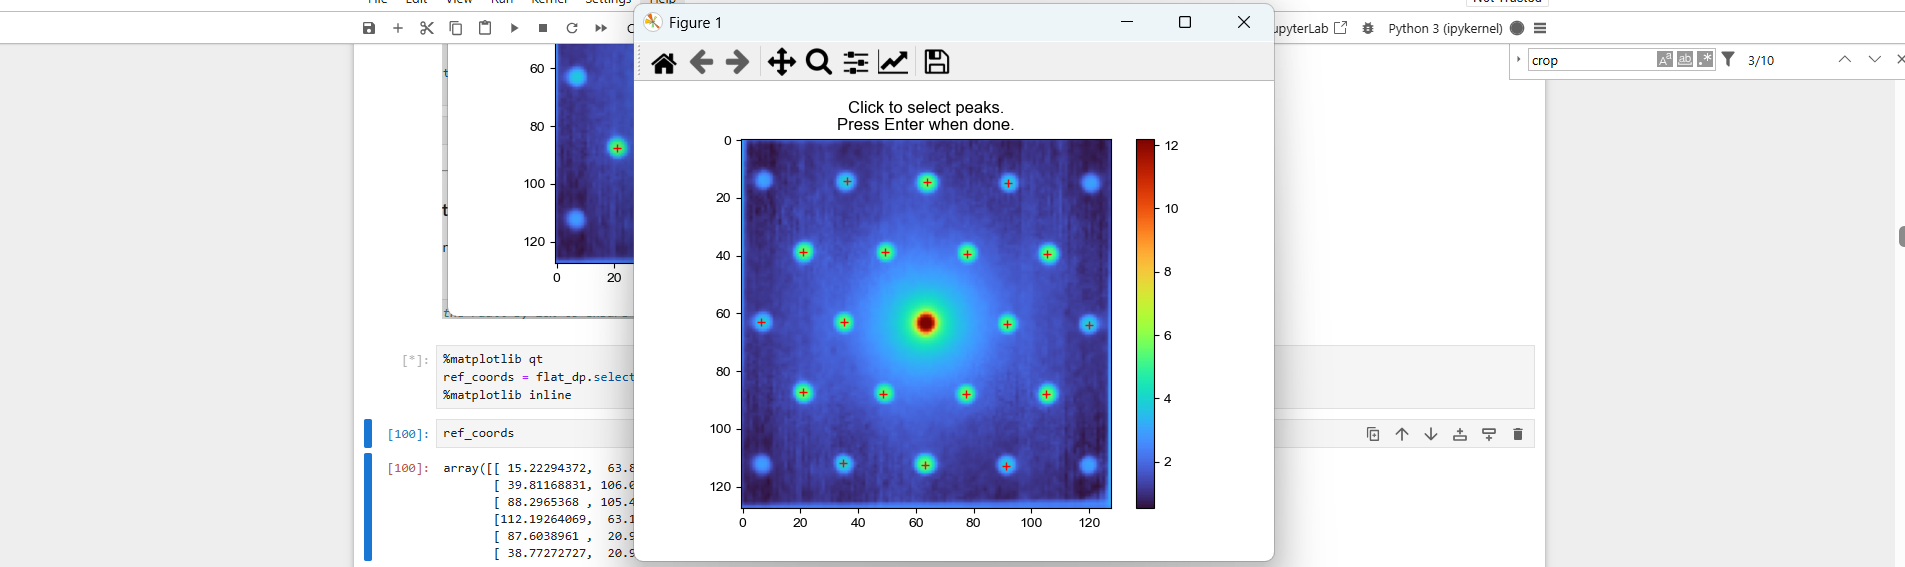

In [23]:
%matplotlib qt
ref_coords = flat_dp.select_peaks(cmap='turbo',)
%matplotlib inline

In [24]:
ref_coords

array([[ 39.81168831,  77.35281385],
       [ 63.36147186,  90.85930736],
       [ 86.91125541,  77.00649351],
       [ 86.91125541,  49.3008658 ],
       [ 63.01515152,  36.14069264],
       [ 39.46536797,  49.64718615],
       [ 15.91558442,  64.19264069],
       [ 39.81168831, 104.71212121],
       [ 87.25757576, 104.36580087],
       [111.15367965,  63.15367965],
       [ 86.56493506,  22.28787879],
       [ 39.46536797,  22.98051948],
       [ 15.91558442,  91.8982684 ],
       [ 63.01515152, 118.21861472],
       [110.46103896,  90.85930736],
       [110.11471861,  36.14069264],
       [ 62.32251082,   8.08874459],
       [ 15.91558442,  36.83333333]])

### 2.2. Find the center-of-mass for all Bragg peaks for all diffraction patterns

Here, we use the array **ref_coords** as the reference (starting point "guess") for the location of the peaks' center-of-mass.

In [25]:
all_Centers = superlattice_data.get_centers(r=5, ref_coords=ref_coords, method='CoM')

Computing centers (4D): 100%|██████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 15.20it/s]


In [397]:
np.save('all_Centers.npy', all_Centers)

### 2.3. Compute Intensities 

We compute the intensity for the first 6 peaks of interest.

In [26]:
all_intensities = superlattice_data.get_intensities(r=5.25, 
                                                    centers=all_Centers, 
                                                    method='CoM')

print(f"A total of {all_intensities.shape[2]} intensities were calculated for each diffraction pattern.")

Calculating intensities: 100%|█████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 17.38it/s]

A total of 18 intensities were calculated for each diffraction pattern.


We normalize based on flat region intensities.

In [27]:
flat_intensities = flat_dp.get_intensities(r=5.25, 
                                           ref_coords=ref_coords, 
                                           method='CoM')

all_intensities /= flat_intensities

In [396]:
np.save('all_intensities.npy', all_intensities)

From the 18 Bragg peaks, the first 6 correspond to first order, the next 6 to second order, and the last 6 to 3rd order.
We display a dark-field virtual image for each of the peaks, order left to right top to bottom

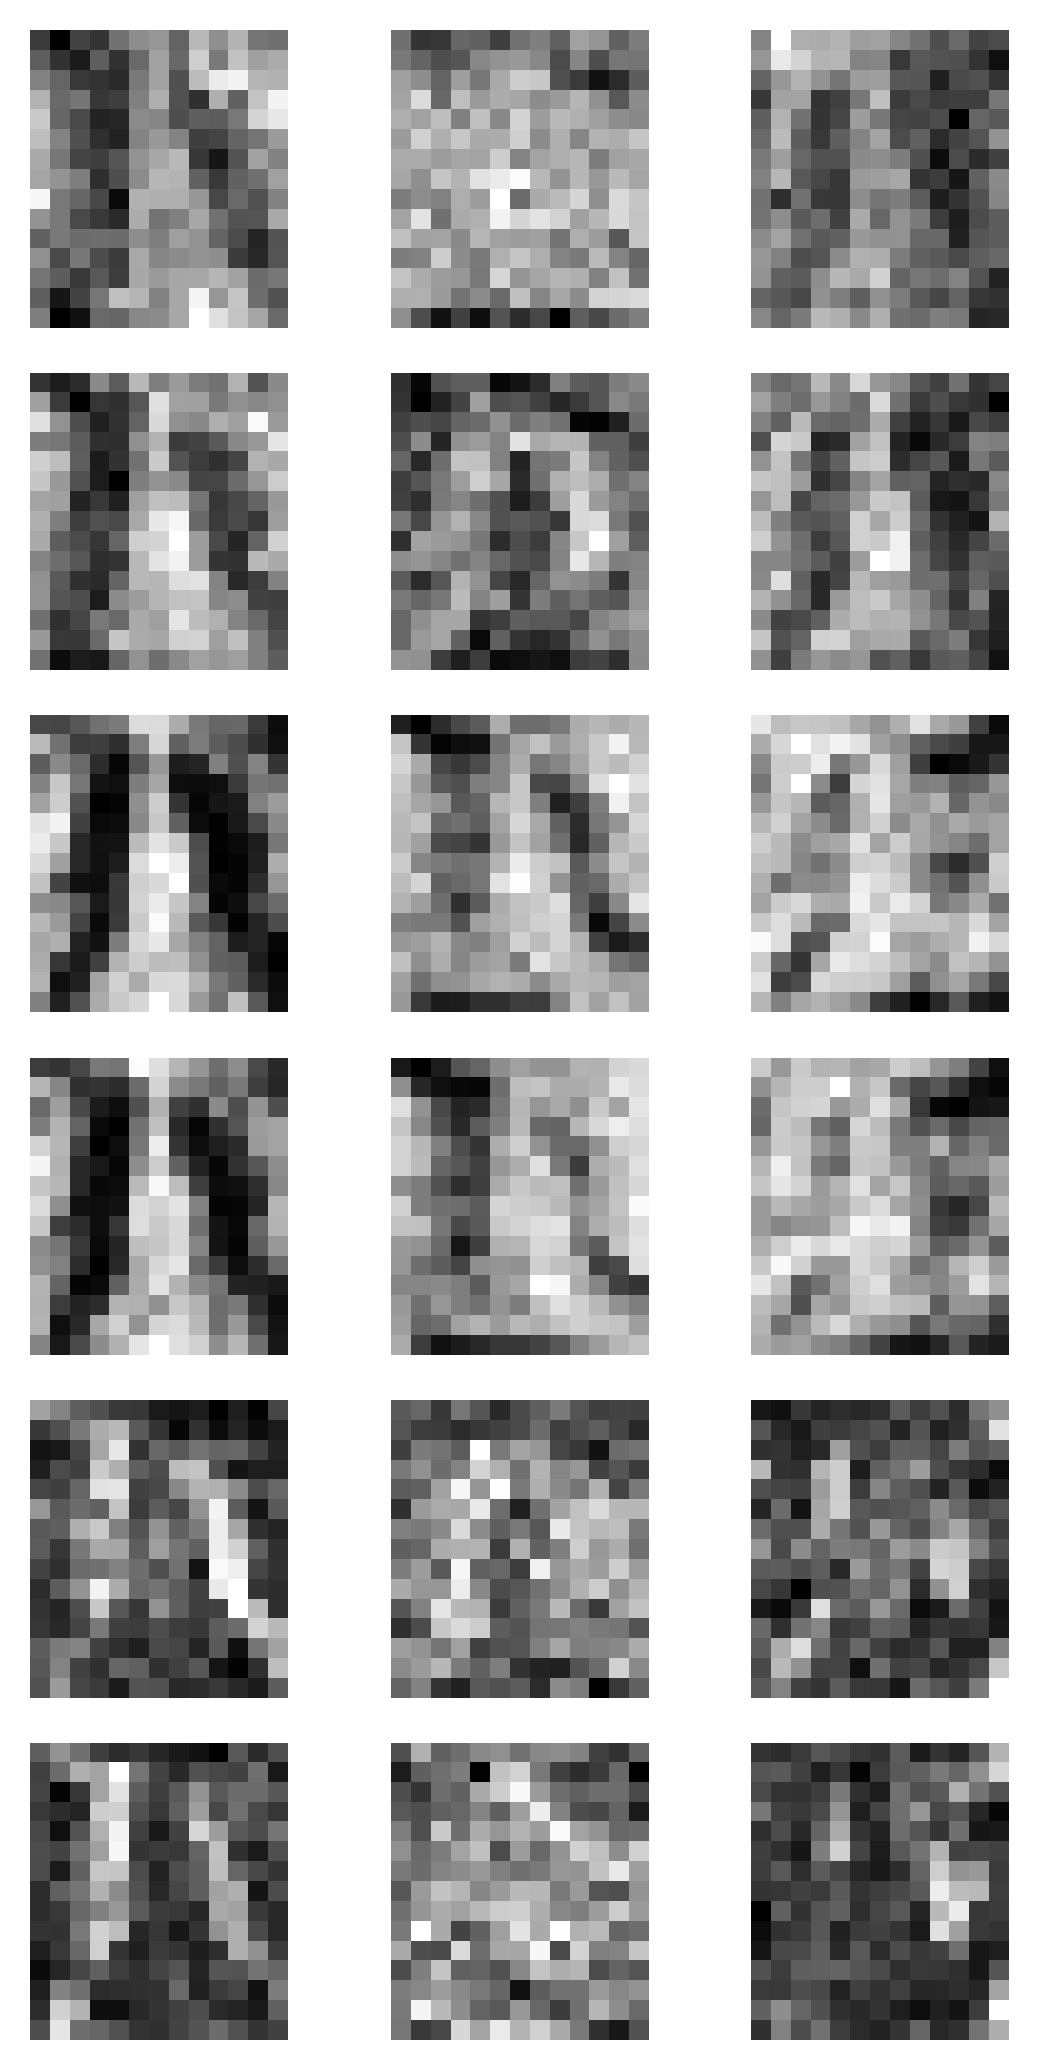

In [28]:
# We will now plot a virtual image for each of the peaks
fig, axes = plt.subplots(6, 3, figsize=(4, 7), dpi=300)

for i in range(18):
    ax = axes[i//3, i % 3]  # Determine position in 6x3 grid
    ax.imshow(all_intensities[:, :, i], cmap='gray')  # Adjust slicing as necessary
    ax.axis('off')
    # ax.set_title(f'Peak {i + 1}')  # Title for each plot

plt.tight_layout()
plt.show()

## 3. Three-dimensional Reconstruction

In order to map the **out-of-plane topology** of the material in question, we define two "tilt descriptors" $(\phi, \theta)$, where the angle $\phi$ is the azimuthal angle and $\theta$ the elevation angle. Each diffraction pattern in the four-dimensional dataset has a unique pair of tilt descriptors which describes its orientation.

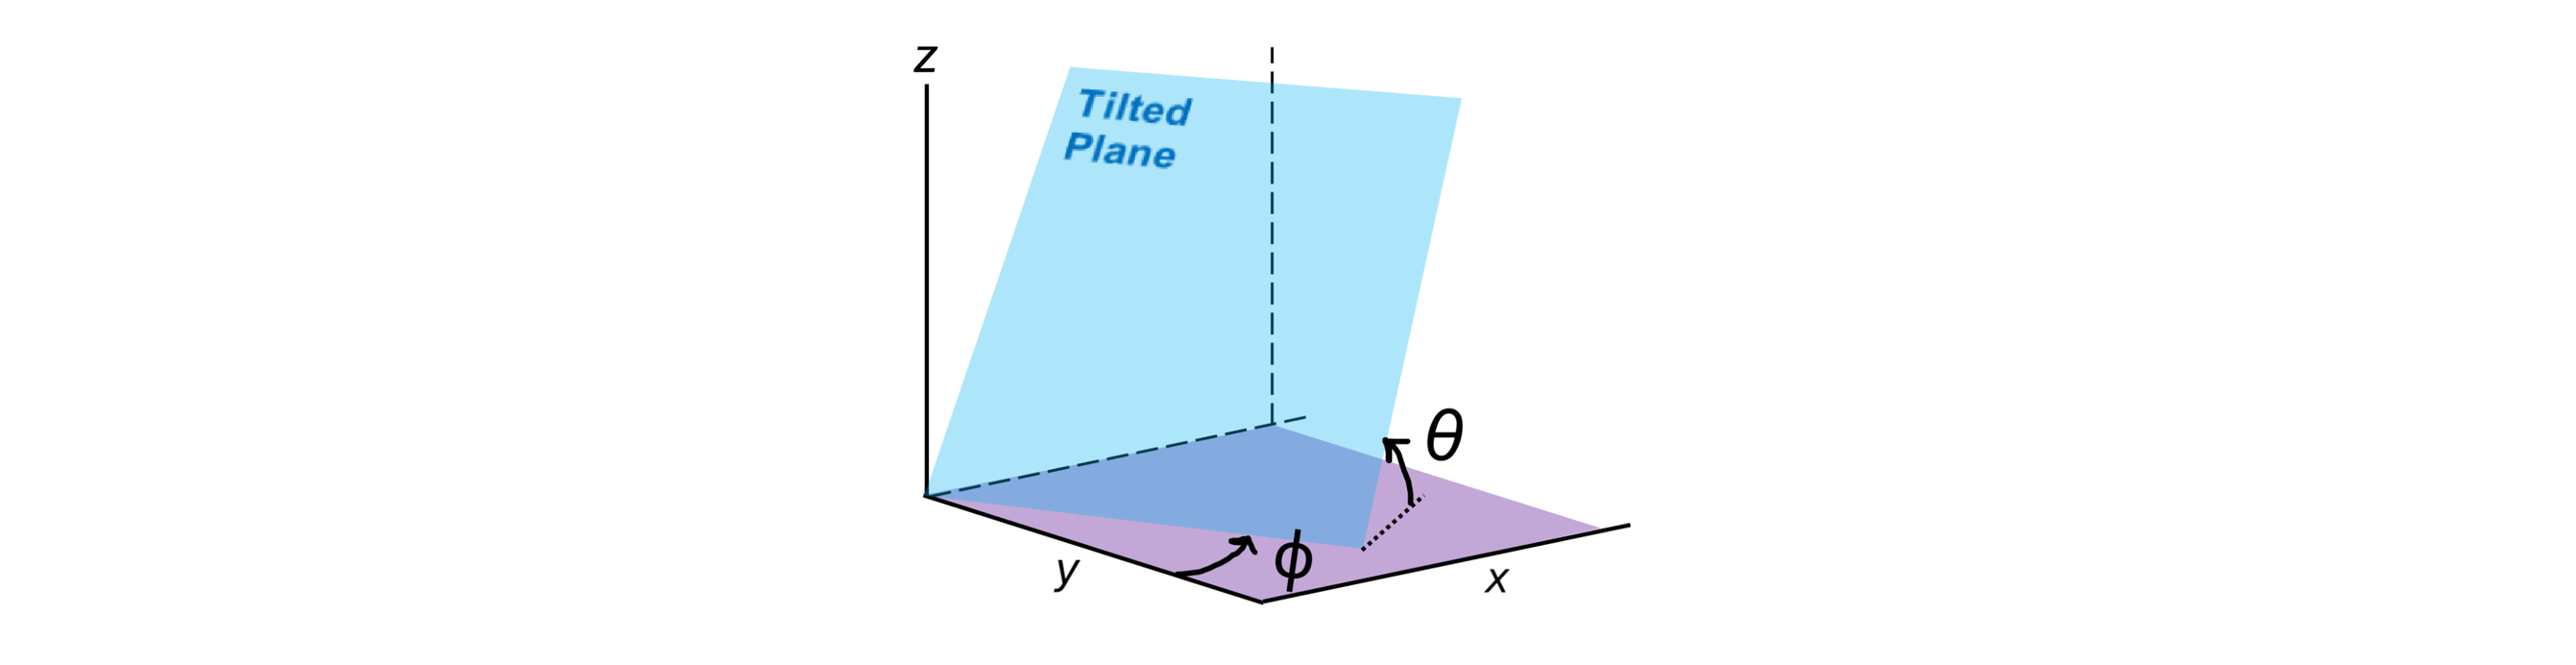

### 3.1. Generate a Library of Simulation Data

We first generate a library of simulations based on a **kinematic diffraction model**. This model is based on that in  [S. H. Sung, et al (2019)](https://doi.org/10.1103/PhysRevMaterials.3.064003) and allows for a forward mapping $f(\phi, \theta) = [I_1 ... I_6]$ correpsonding to the intensities of six Bragg peaks at a user-defined "diffraction order" (the higher the order, the further the peaks from the central electron beam). 

In the following step, we input a range of combinations of $(\phi, \theta)$, where the range of $\phi$ is defined by the parameter `phi_range` and, that of $\theta$, by `theta_range`. We specify the number of values tested using `num_phis` and `num_thetas`. 

In [30]:
sim_ints_array = generate_library(phi_range=(0,360), num_phis=181,       # Specify range and number of values simulated    
                                  theta_range=(0,30), num_thetas=151,     # Specify range and number of values simulated        
                                  save=True, fname='sim_ints_MoSe2.npy', # Optionaly, save the generated library
                                  material='MoSe2', a=3.32, order=2,     # Kinematic diffraction simulation arguments
                                  normalization='flat_max', keV=80,      # Kinematic diffraction simulation arguments
                                 )

print(r"([Number (" + "\N{greek small letter phi}," + \
       " \N{greek small letter theta}" + ") Pairs], [\N{greek small letter phi}," + \
       " \N{greek small letter theta}, I₁, I₂, I₃, I₄, I₅, I₆]) =", sim_ints_array.shape)

Generating library of (phi, theta, intensities): 100%|██████████████████████████| 27331/27331 [02:14<00:00, 203.74it/s]

Saved all data as: sim_ints_MoSe2.npy
([Number (φ, θ) Pairs], [φ, θ, I₁, I₂, I₃, I₄, I₅, I₆]) = (27331, 8)


In [31]:
np.save("sim_ints_array.npy", sim_ints_array)

In [32]:
# Alternatively, directly load a previously generated library of kinematic diffraction simulations
sim_ints_array = np.load('sim_ints_array.npy')

### 3.2. Compute Tilt Maps and Surface Gradients

We now find the optimal combinations of $(\phi, \theta)$ for each set of **second order intensities** $[I_1 ... I_6]$ extracted from each real-space position using the `get_tilts` function. The output `tilts` will be of shape (Real$_\text{Y}$, Real$_\text{X}$, 2), where the last index corresponds to the two values $\phi$ and $\theta$.

Finding optimal (phi, theta): 100%|████████████████████████████████████████████████████| 15/15 [00:00<00:00, 18.07it/s]


<Figure size 1000x1000 with 0 Axes>

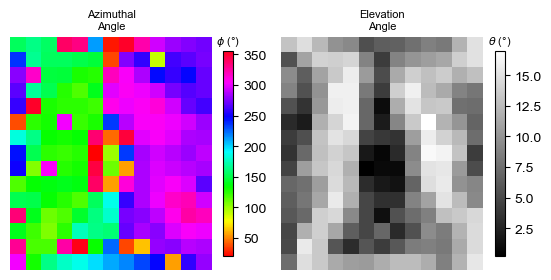

In [34]:
# Compute tilts
plt.figure(figsize=(10,10))
tilts = get_tilts(intensity_array=all_intensities[:,:,6:12],
                  show_result=True, figsize=(5.5, 5),
                  method='grid_search', 
                  loss='euclidean_distance', 
                  simDataArray=sim_ints_array)

In [395]:
np.save('./tilts.npy', tilts)

### 3.3 Reconstruct Surface

We convert the tilt maps into perpendicular surface gradients using the `get_gradients` function.

In [409]:
get_gradients?

Signature:
get_gradients(
    sol_array,
    rot_angle=0,
    show_result=False,
    invertY=False,
    invertX=False,
    cbar_fraction=0.04,
)
Docstring:
Calculate directional gradients from a solution array of (phi, theta) values.

This function computes the directional gradients (dz/dx and dz/dy) from a solution array that 
contains azimuthal (phi) and elevation (theta) angles. The gradients are computed considering 
a specified rotation angle. Optionally, the gradients can be visualized as 2D images.

Parameters
----------
sol_array : ndarray
    A 3D numpy array of shape (rows, cols, 2) where the last dimension represents the angles 
    (phi, theta) in radians.
rot_angle : float, optional
    The rotation angle in degrees to adjust the azimuthal angle (phi). Default is 0.
show_result : bool, optional
    If True, displays the gradients as images with colorbars. Default is False.
invertY : bool, optional
    If True, inverts the y-axis gradient. Default is False.
invertX : bool, 

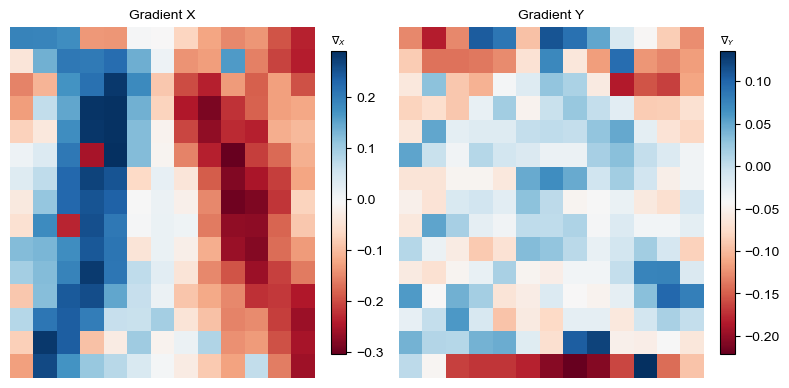

In [39]:
grads = get_gradients(tilts, 
                      rot_angle=30, # 'rot_angle' is for use to specify the positive/negative X and Y directions 
                      show_result=True, invertY=False, invertX=False,
                      cbar_fraction=0.0451)  # 'rot_angle' is for use to specify the positive/negatice X and Y directions

The gradients can then be directly inputted into `reconstruct_height` to obtain a height map.

In [40]:
hmap = reconstruct_height(xGrad=grads[:,:,0], 
                          yGrad=grads[:,:,1], 
                          y_bds_flat=(2,11), 
                          x_bds_flat=(0,1), 
                          iterations=10, 
                          threshold_percent=1, 
                          plot=False, 
                          returnGradients=False,
                          max_window_size=3)

C:\Users\haloe\Documents\CodeWriting\4Denoise\helpers\fourdenoise.py:1153: RuntimeWarning: divide by zero encountered in reciprocal
  q2inv = np.reciprocal(q2a)
Reconstructing height: 100%|███████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54it/s]


(-0.5, 12.5, 14.5, -0.5)

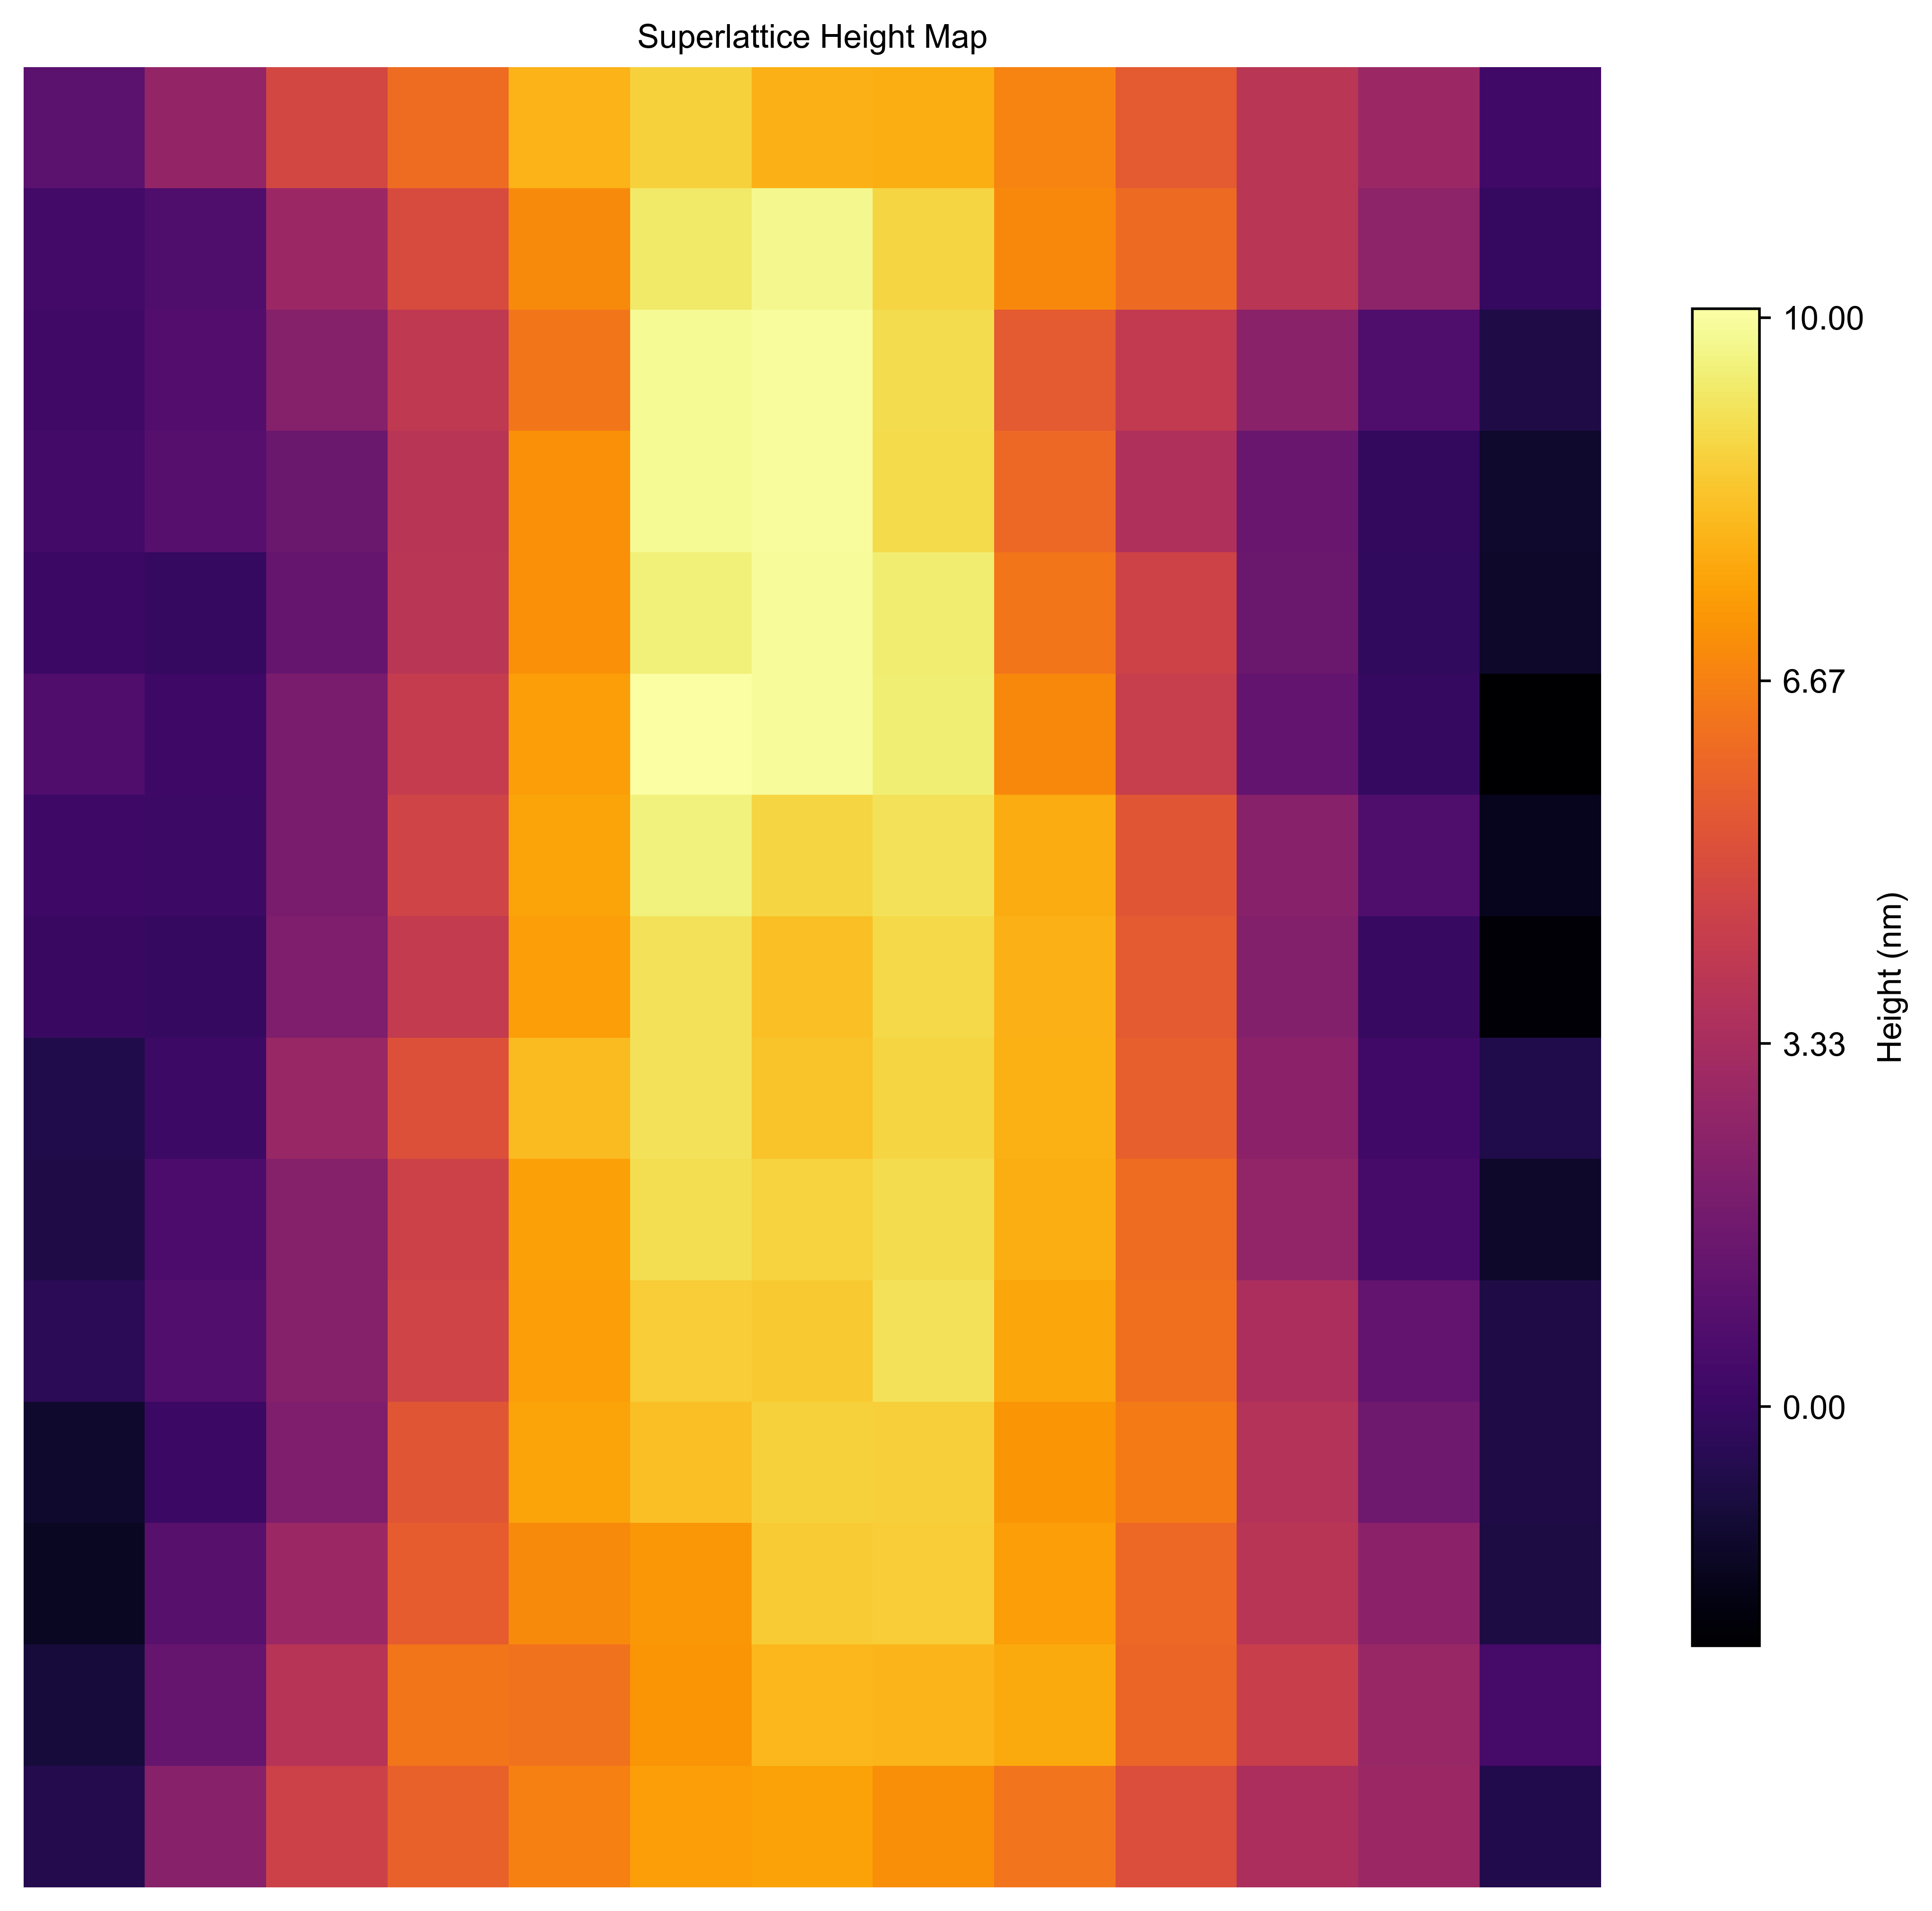

In [42]:
mag = 75 # 75000X magnification
conversion_factor = 0.46*840/mag*2 #nm/px

plt.figure(figsize=(10,10), dpi=500)
plt.imshow(hmap*conversion_factor, cmap='inferno')
cbar = plt.colorbar(label='Height (nm)', ticks=np.linspace(-20, 20, 13),fraction=0.0365,)
plt.title('Superlattice Height Map', fontsize=10)
plt.axis('off')

In [394]:
np.save('./height_map.npy', hmap)

Save the data as `.mat` files for the interactive GUI in MATLAB.

In [1847]:
save_mat_data(hmap, 
              save_dir + '/height_map.mat', 
              'height_map')

save_mat_data(haadf, 
              save_dir + '/haadf.mat', 
              'haadf')

save_mat_data(tilts, 
              save_dir + '/tilts.mat', 
              'tilts')

For verification purposes, we now visualize the tilt maps and the gradient maps of the reconstructed height map.

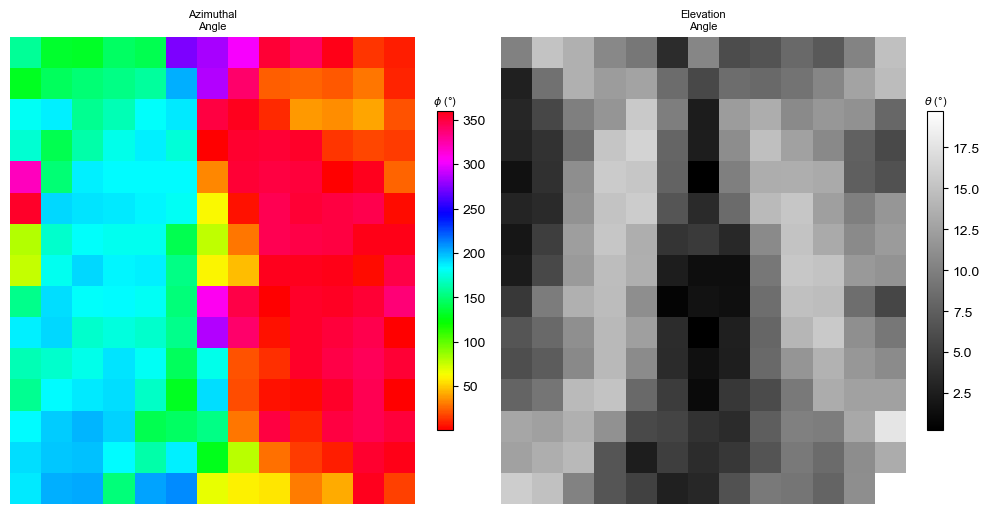

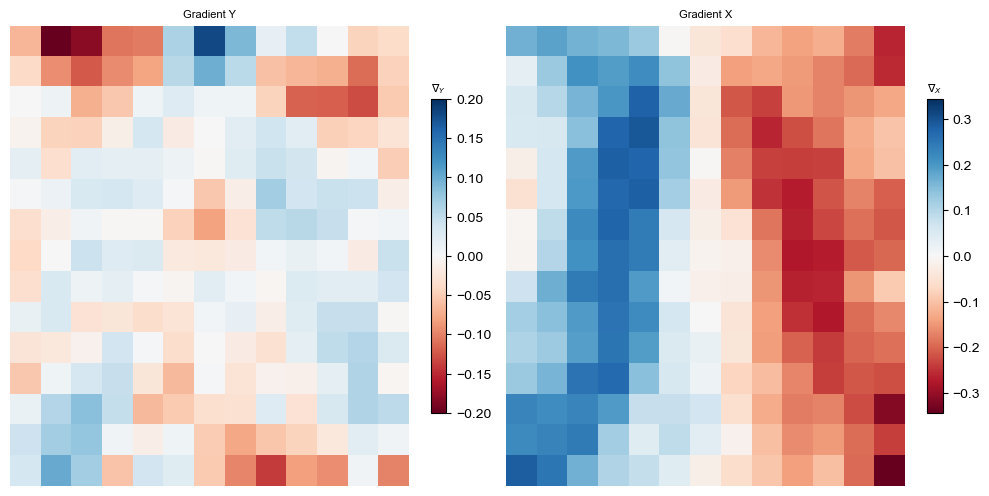

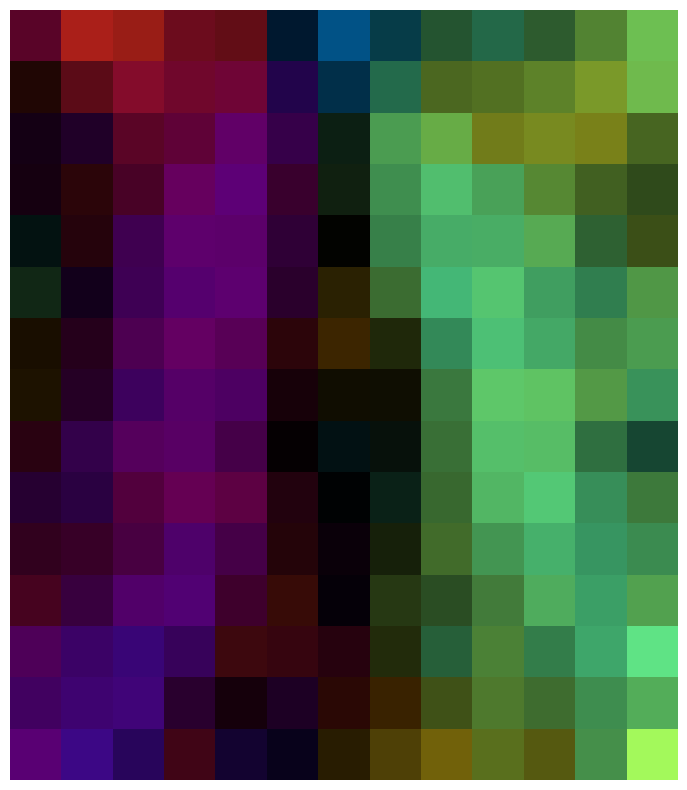

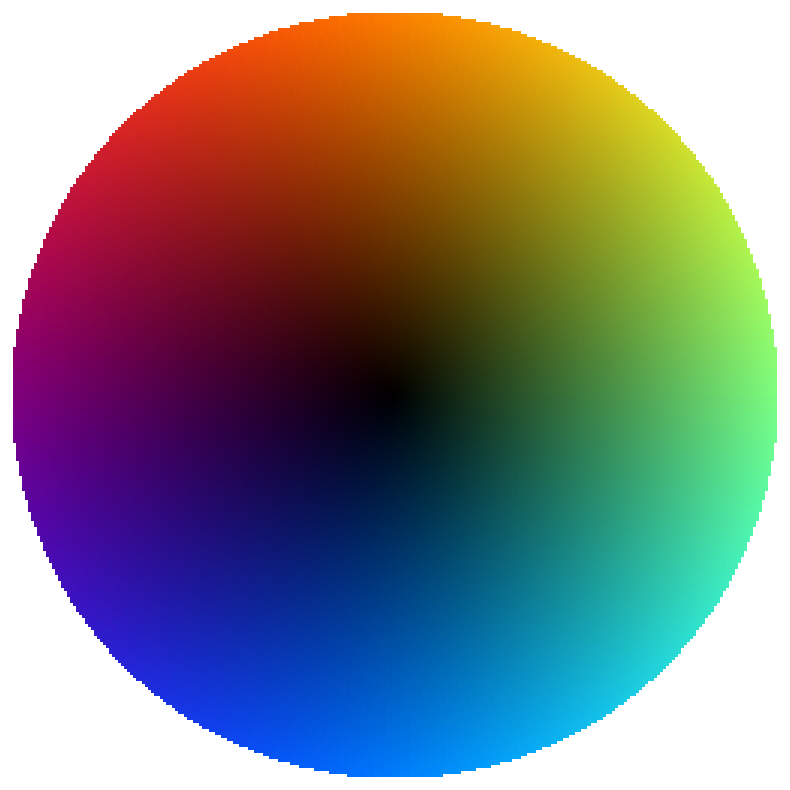

In [44]:
ripple_tilt_axis, ripple_tilt = get_surface_tilt_and_direction(hmap, units='rad', show_results=False)

tilts2 = np.stack((ripple_tilt_axis, 
                   ripple_tilt), axis=2)

fig, axs = plt.subplots(1, 2, figsize=(10, 6.25))

# Tilt axis (azimuth)
im1 = axs[0].imshow(np.degrees(tilts2[:, :, 0]), cmap='hsv')
axs[0].axis('off')
axs[0].set_title('Azimuthal\nAngle', fontsize=8)
cbar1 = fig.colorbar(im1, ax=axs[0], fraction=0.036)
cbar1.ax.set_title(r'$\phi$ (°)', fontsize=8, pad=5)

# Tilt magnitude (elevation)
im2 = axs[1].imshow(np.degrees(tilts2[:, :, 1]), cmap='gray')
axs[1].axis('off')
axs[1].set_title('Elevation\nAngle', fontsize=8)
cbar2 = fig.colorbar(im2, ax=axs[1], fraction=0.036)
cbar2.ax.set_title(r'$\theta$ (°)', fontsize=8, pad=5)

plt.tight_layout()
plt.show()

grads2 = get_gradients(tilts2, rot_angle=180)
fig, axs = plt.subplots(1, 2, figsize=(10, 6.25))

# Y-gradient 
lim_val = np.max(np.abs(grads2[:,:,0]))
im1 = axs[0].imshow(grads2[:,:,0], cmap='RdBu', vmin=-lim_val, vmax=lim_val)
axs[0].axis('off')
axs[0].set_title('Gradient Y', fontsize=8)
cbar1 = fig.colorbar(im1, ax=axs[0], fraction=0.036)
cbar1.ax.set_title(r'$\nabla_Y$', fontsize=8, pad=5)

# X-gradient
lim_val = np.max(np.abs(grads2[:,:,1]))
im2 = axs[1].imshow(grads2[:,:,1], cmap='RdBu', vmin=-lim_val, vmax=lim_val)
axs[1].axis('off')
axs[1].set_title('Gradient X', fontsize=8)
cbar2 = fig.colorbar(im2, ax=axs[1], fraction=0.036)
cbar2.ax.set_title(r'$\nabla_X$', fontsize=8, pad=5)

plt.tight_layout()
plt.show()

# We visualize a combined tilt/tilt direction map (hue is direction and brightness the magnitude of elevation)
from rippleModel import * # ripple, calculate_surface_tilt, phplot
phplot((ripple_tilt_axis, ripple_tilt), Amp='raw', scale=True, subplot=False);

## 4. Strain Mapping

### 4.1. Identifying a Flat Region

The user may find a flat region by manually  averaging diffraction patterns in a real-space region via the `.get_dp()` method or by using an automatic approach as shown below.

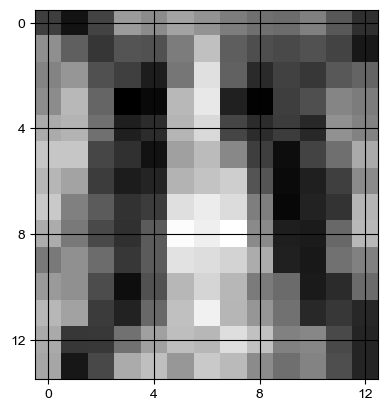

In [47]:
# We visualize a region in which we know the "flat" reference region exists.
y_upper = 0
y_lower = 14

_ = superlattice_data.crop(ylim=(y_upper,y_lower),).get_virtualImage(35, 50, num_div=(3,3))
del(_)

We automatically identify the most flat regions by finding those diffraction patterns for which the second-order intensities have a low standard deviation. We pick the first 10% of diffraction patterns which exhibit this flat behavior.

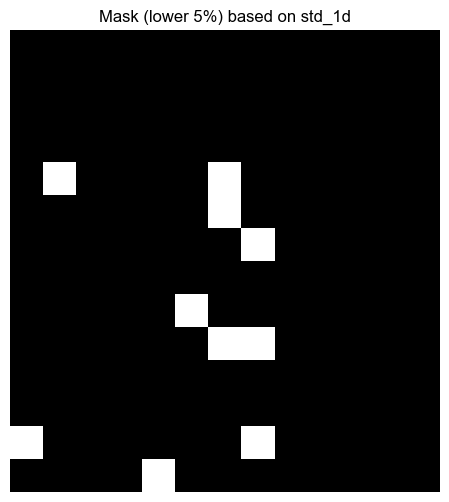

In [49]:
mose2_region_intensities = all_intensities[y_upper:y_lower,:,][:,:,6:12] # Note we pick peaks with indices 6-12 since those are 2nd-order

flat_intensities, flat_mask = mask_and_average(mose2_region_intensities, function='std_1d', percentile=5, threshold='lower', return_mask=True)

We apply the mask to the `all_Centers` array to get the **reference** centers-of-mass.

In [50]:
ref_positions = np.mean(all_Centers[y_upper:y_lower, :][flat_mask], axis=0)

### 4.2. Strain Mapping Using All 18 Bragg Peaks 

In [51]:
strain_maps = np.zeros((3,4,all_Centers.shape[0],all_Centers.shape[1]))

# Loop over each Bragg peak order 
for i in range(3):

    exx, eyy, exy, theta = superlattice_data.get_strains(centers=all_Centers[:, :, 6*i:6*(i+1)], 
                                                         ref_centers=ref_positions[6*i:6*(i+1)],
                                                         g_vector=None, ang=0
                                                        )
    
    strain_maps[i] = exx, eyy, exy, theta

Computing strain matrices: 100%|██████████████████████████████████████████████████████| 15/15 [00:00<00:00, 163.24it/s]


We weigh the strain maps for each diffraction order based on the intensity of the corresponding Bragg peaks to enhance signal-to-noise ratio.

In [52]:
final_strain_maps = np.zeros((4, all_Centers.shape[0], all_Centers.shape[1]))

for strain_idx in range(4): 

    strain_ints = np.zeros_like(final_strain_maps)
    for order_idx in range(3):
    
        strain_int = strain_maps[order_idx,strain_idx] * np.sum(all_intensities[:,:,6*order_idx:6*(order_idx+1)], axis=2)
        strain_ints[order_idx] = strain_int
    
    final_strain_map = np.sum(strain_ints, axis=0) / np.sum(all_intensities, axis=2)

    if strain_idx == 3:
        final_strain_map = np.degrees(final_strain_map) - 90
        
    final_strain_maps[strain_idx] = final_strain_map

We now find the necessary  rotation of the planar strain components in 2D to properly orient the x and y directions (i.e., we don't want e_xx or e_yy to be inverted or rotated by some random number due to experimental acquisition). To find the x-direction, we use a region with ripples, for the projected compressive strain is maximal when integrated there. Whichever rotation minimizes the pixel-by-pixel sum is considered the rotation we need to find  the necessary rotation.

**Note:** If this angle is known beforehand, it can be introduced directly into `get_strains()` method by using the parameter `ang`.

The strain rotation that minimizes the strain sum over the x-direction is 89.45891783567134°


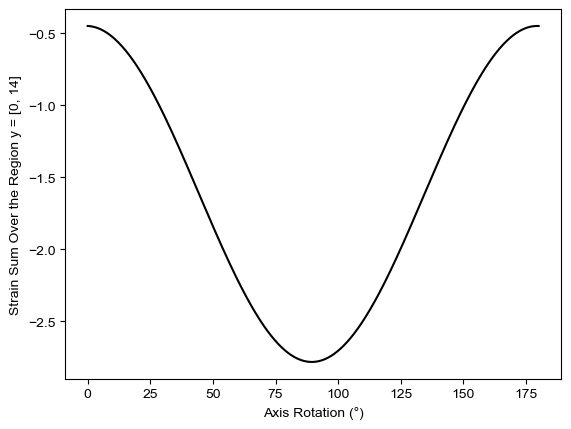

In [53]:
angles = np.linspace(0,180,500)
sums = np.zeros(500)

for i in range(500):

    exx_new, eyy_new, exy_new = rotate_strain(final_strain_maps[0],final_strain_maps[1],final_strain_maps[2], alpha=np.radians(angles[i]))
    sums[i] = np.sum(exx_new[y_upper:y_lower,:])

rot = angles[np.argmin(sums)]
print(f"The strain rotation that minimizes the strain sum over the x-direction is {rot}°")

plt.plot(angles, sums, c='black')
plt.ylabel(f"Strain Sum Over the Region y = [{y_upper}, {y_lower}]")
plt.xlabel("Axis Rotation (°)")
plt.show()

Rotate the strain components so that x and y are properly oriented.

In [54]:
exx, eyy, exy = rotate_strain(final_strain_maps[0],
                              final_strain_maps[1],
                              final_strain_maps[2], 
                              alpha=np.radians(rot))
erot = final_strain_maps[3]

final_strain_maps = np.zeros((4, exx.shape[0], exx.shape[1]))

final_strain_maps[0] = exx
final_strain_maps[1] = eyy
final_strain_maps[2]= exy
final_strain_maps[3] = erot - np.mean(erot)

Visualize the final strain maps (uncorrected)

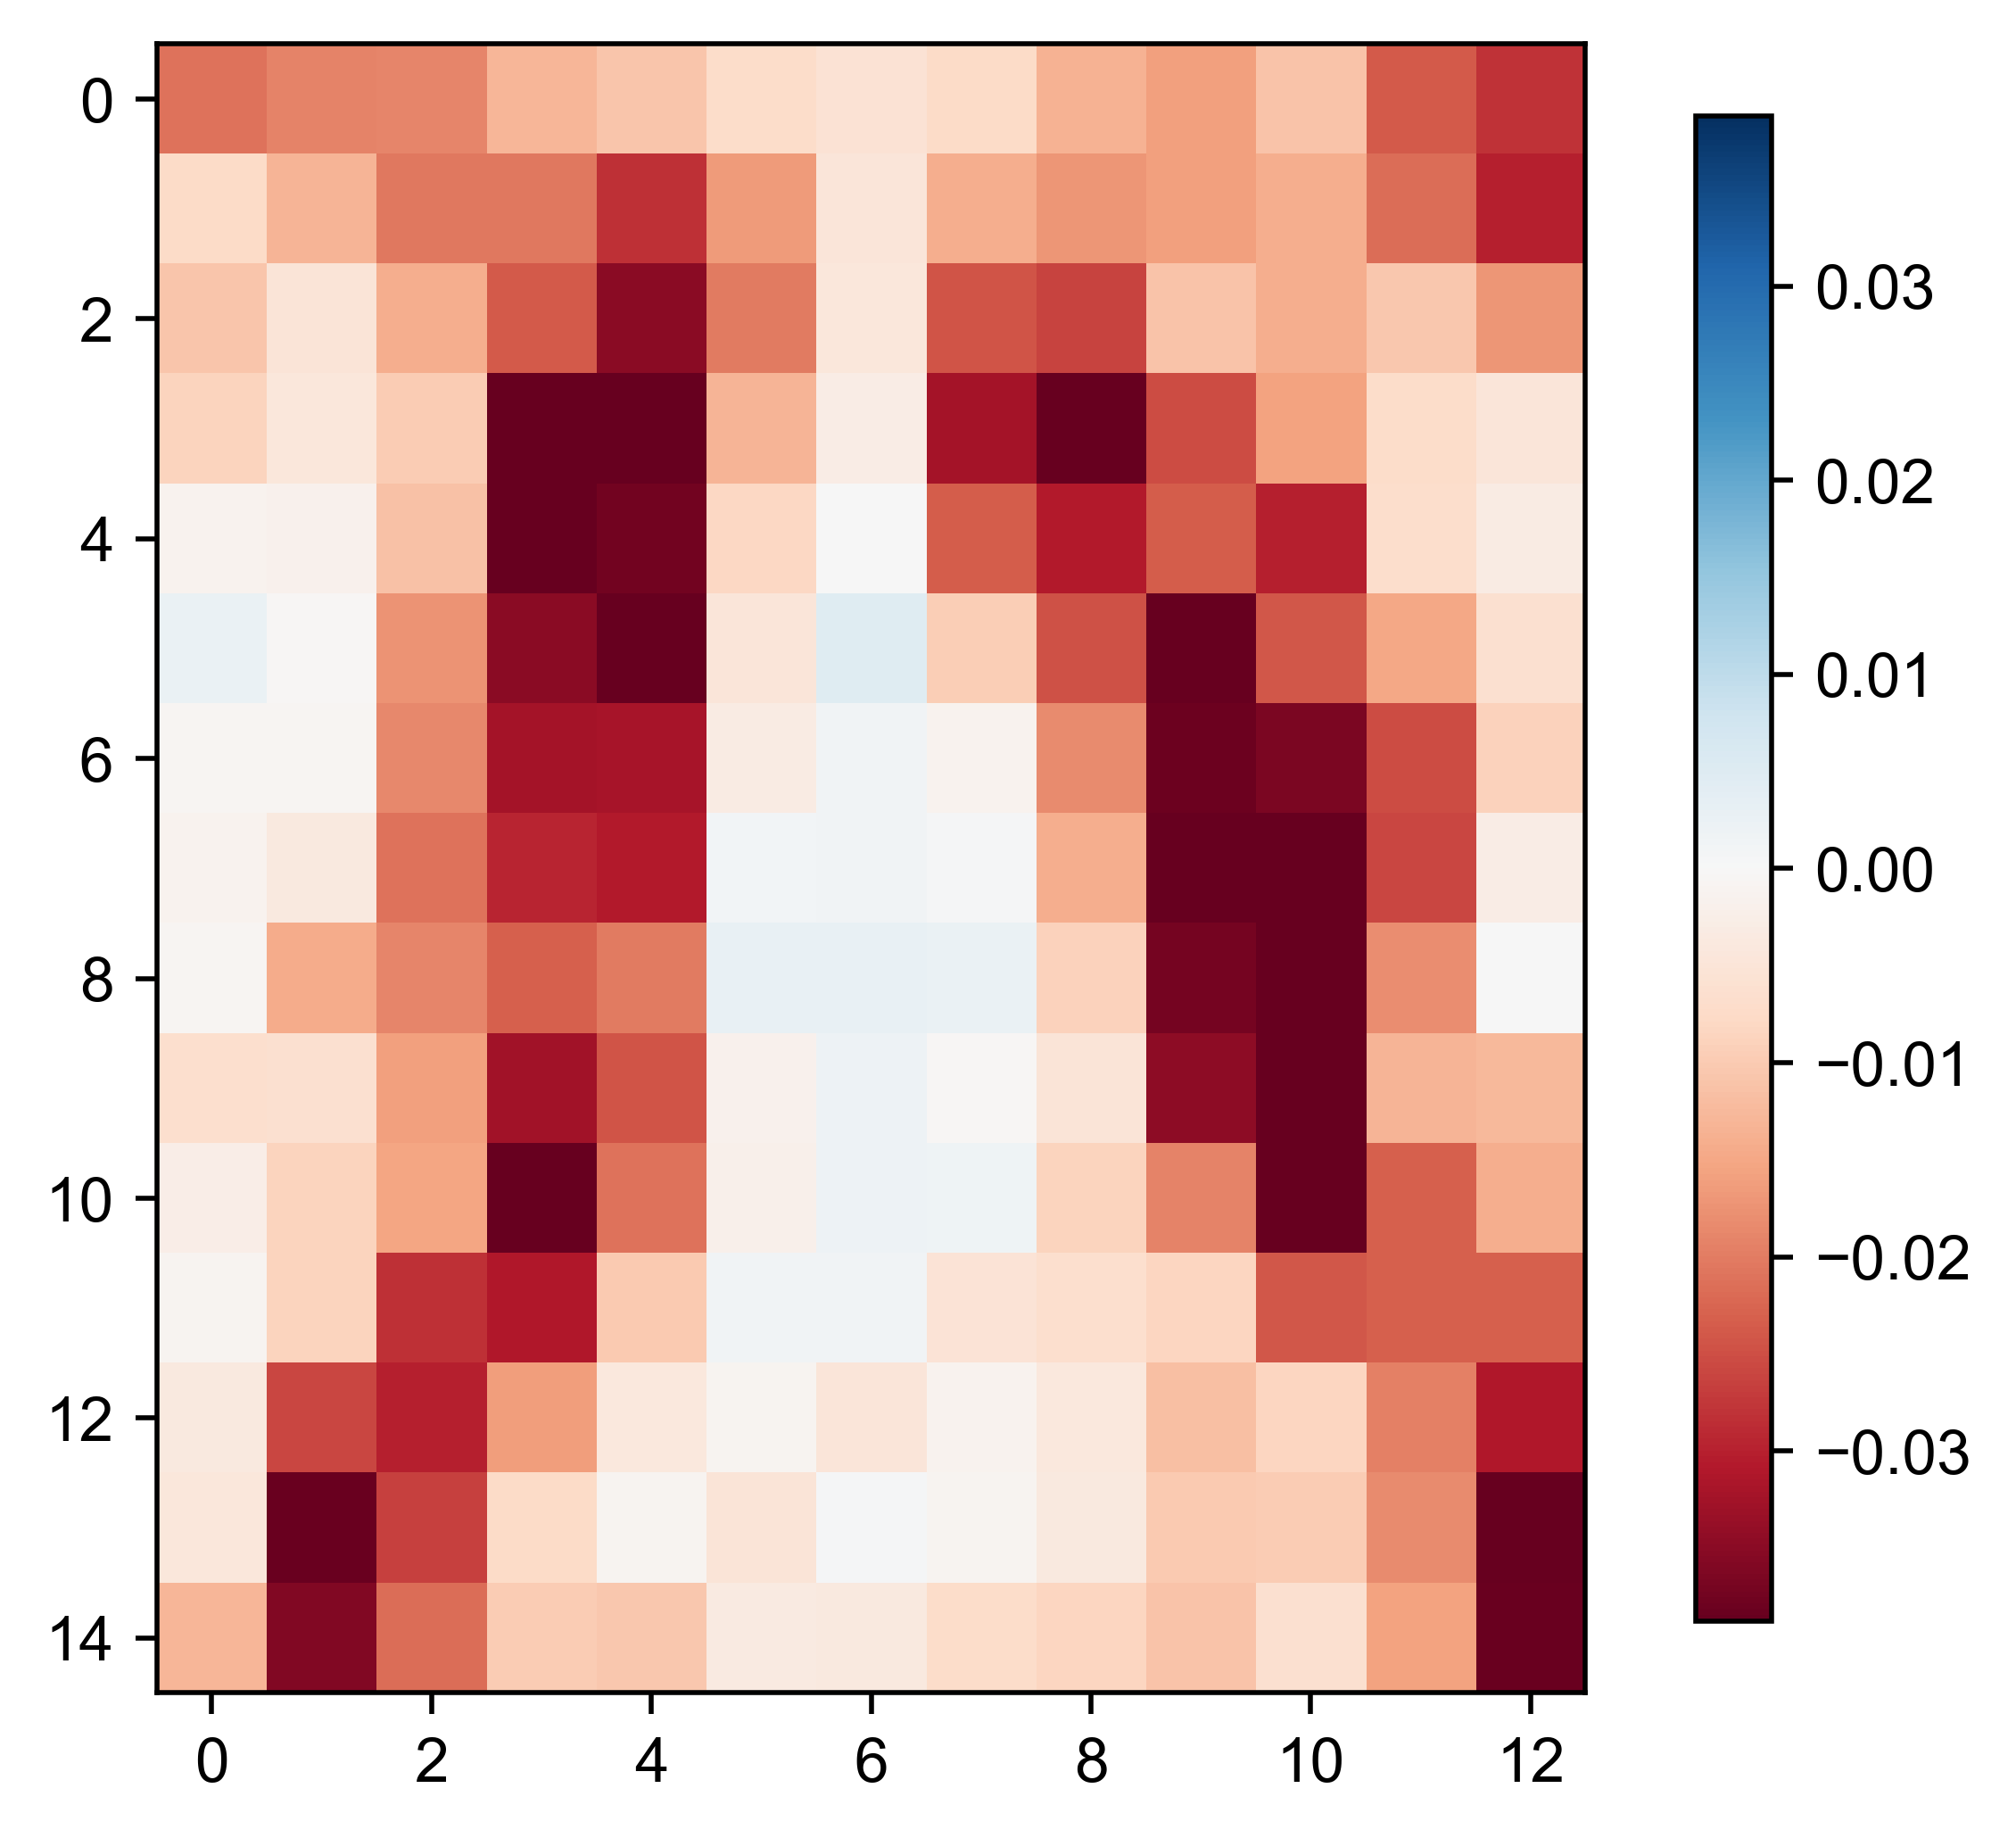

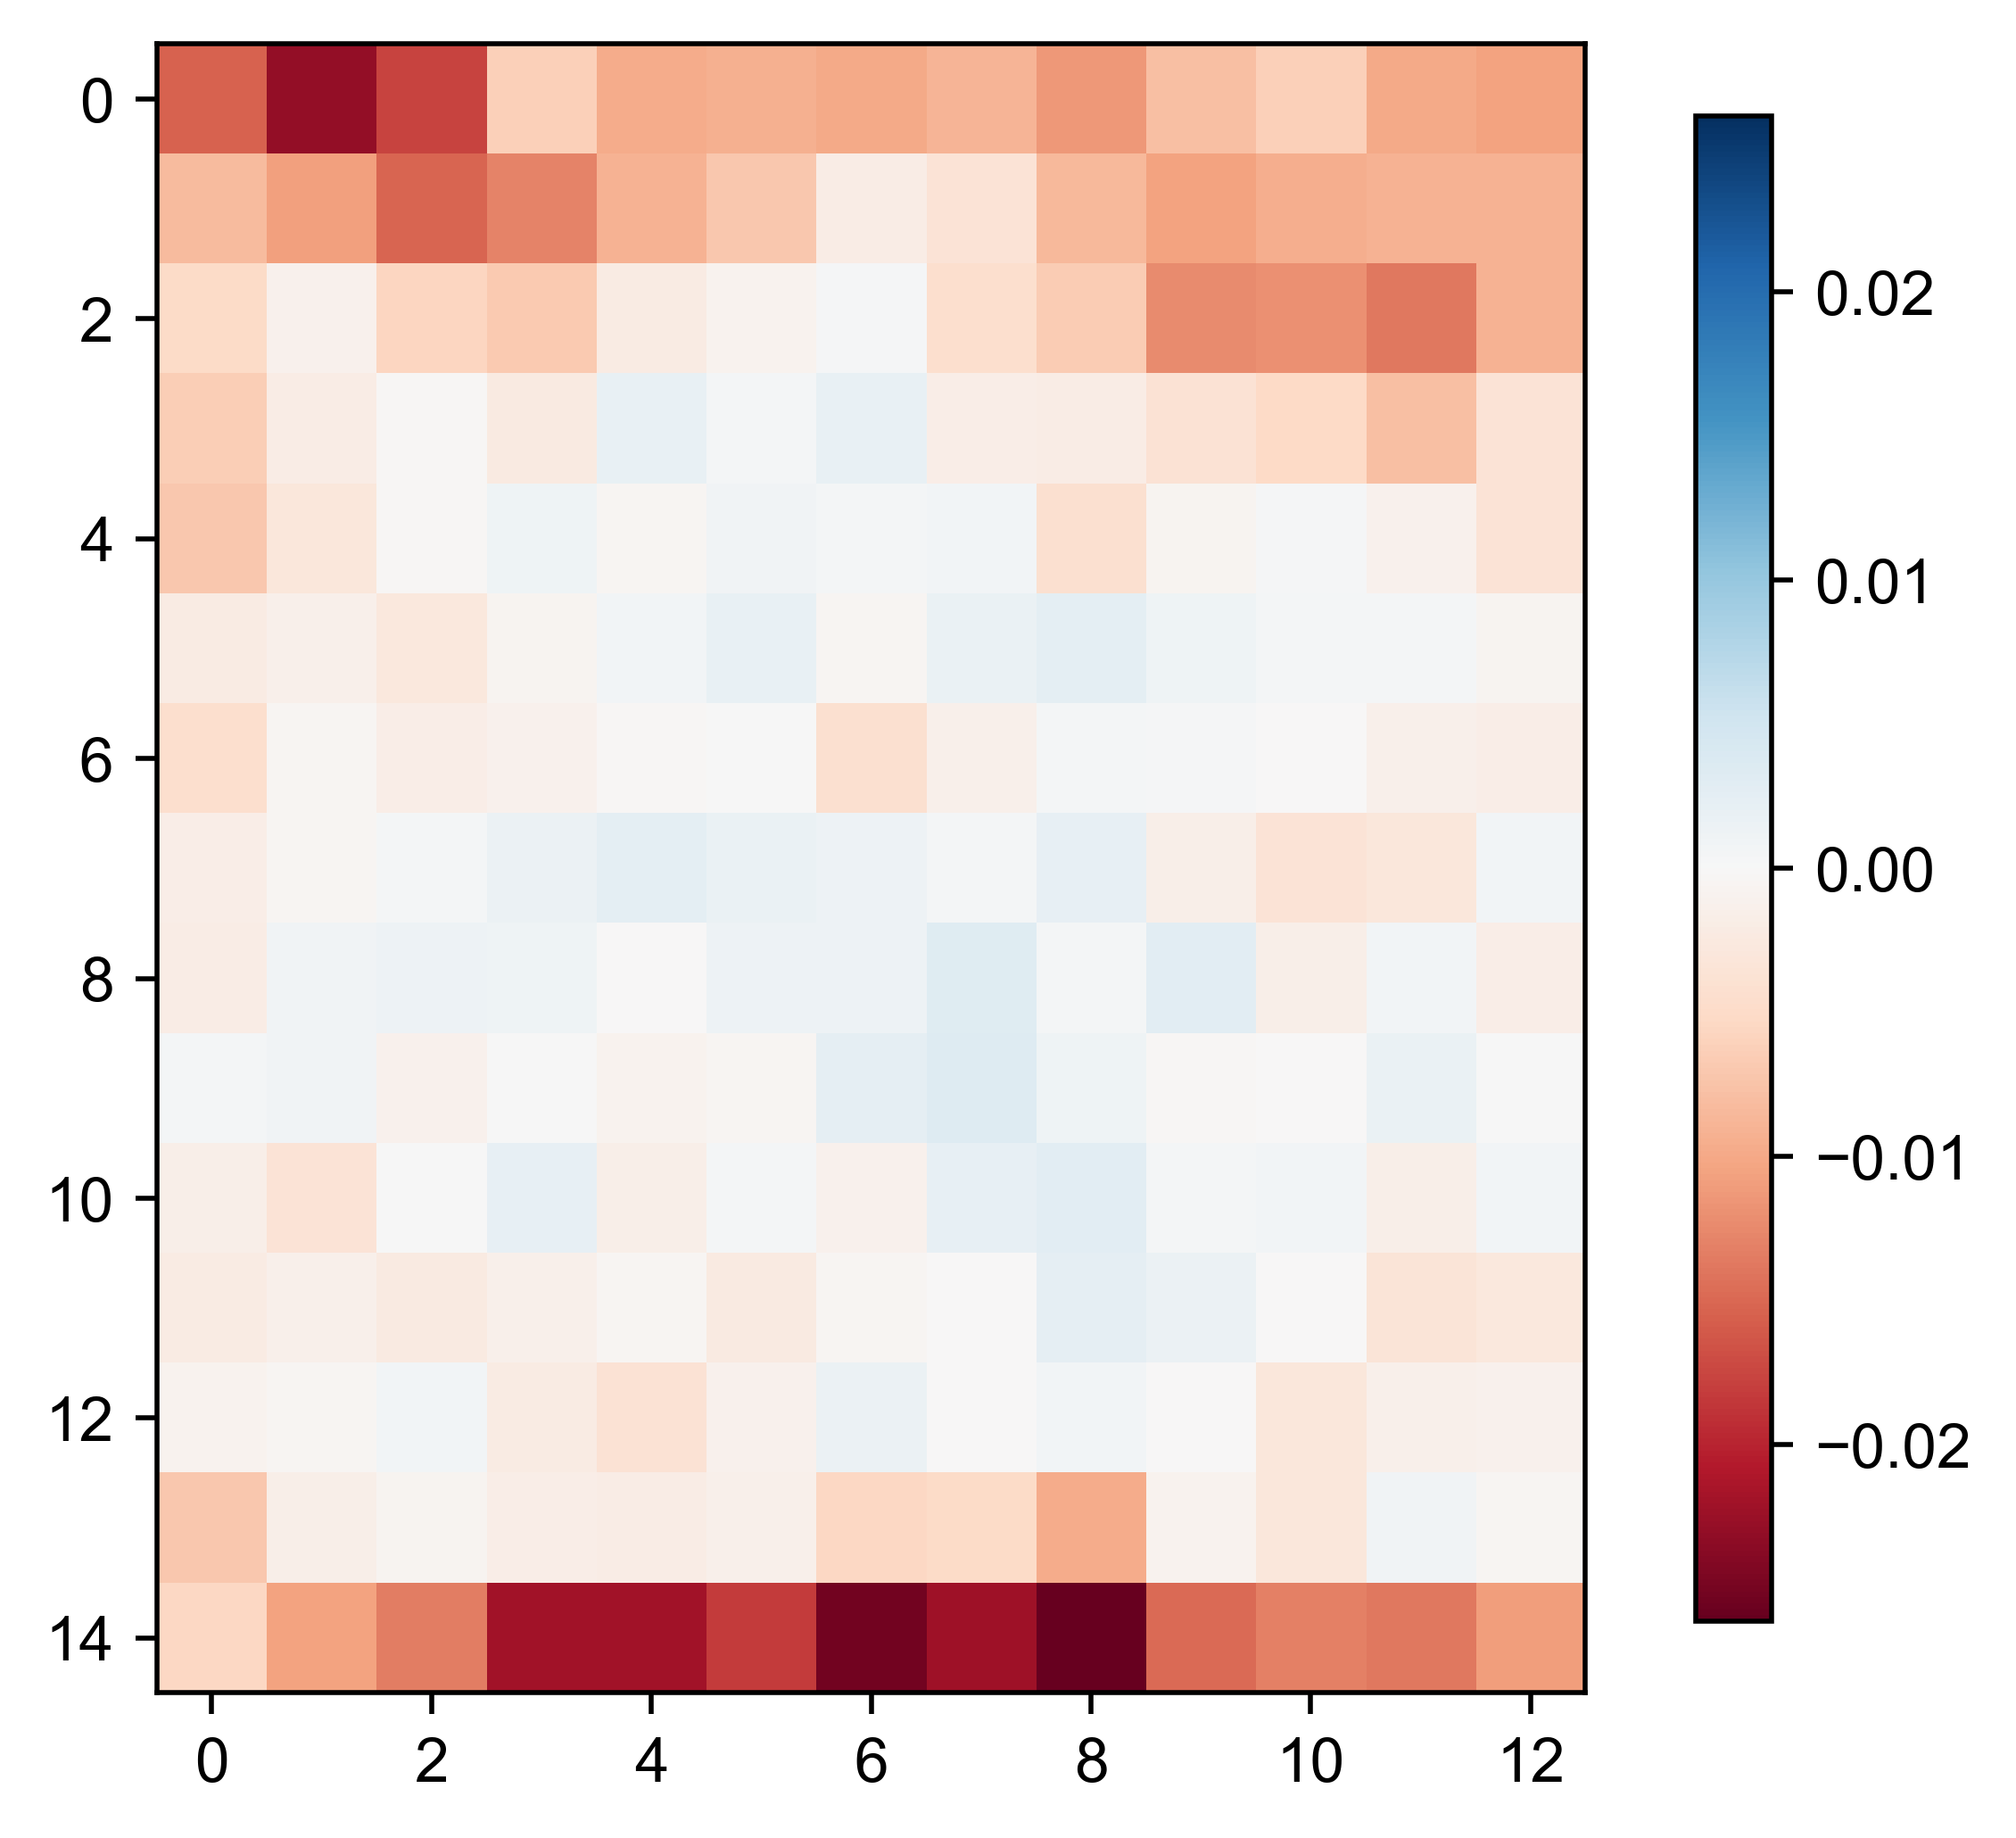

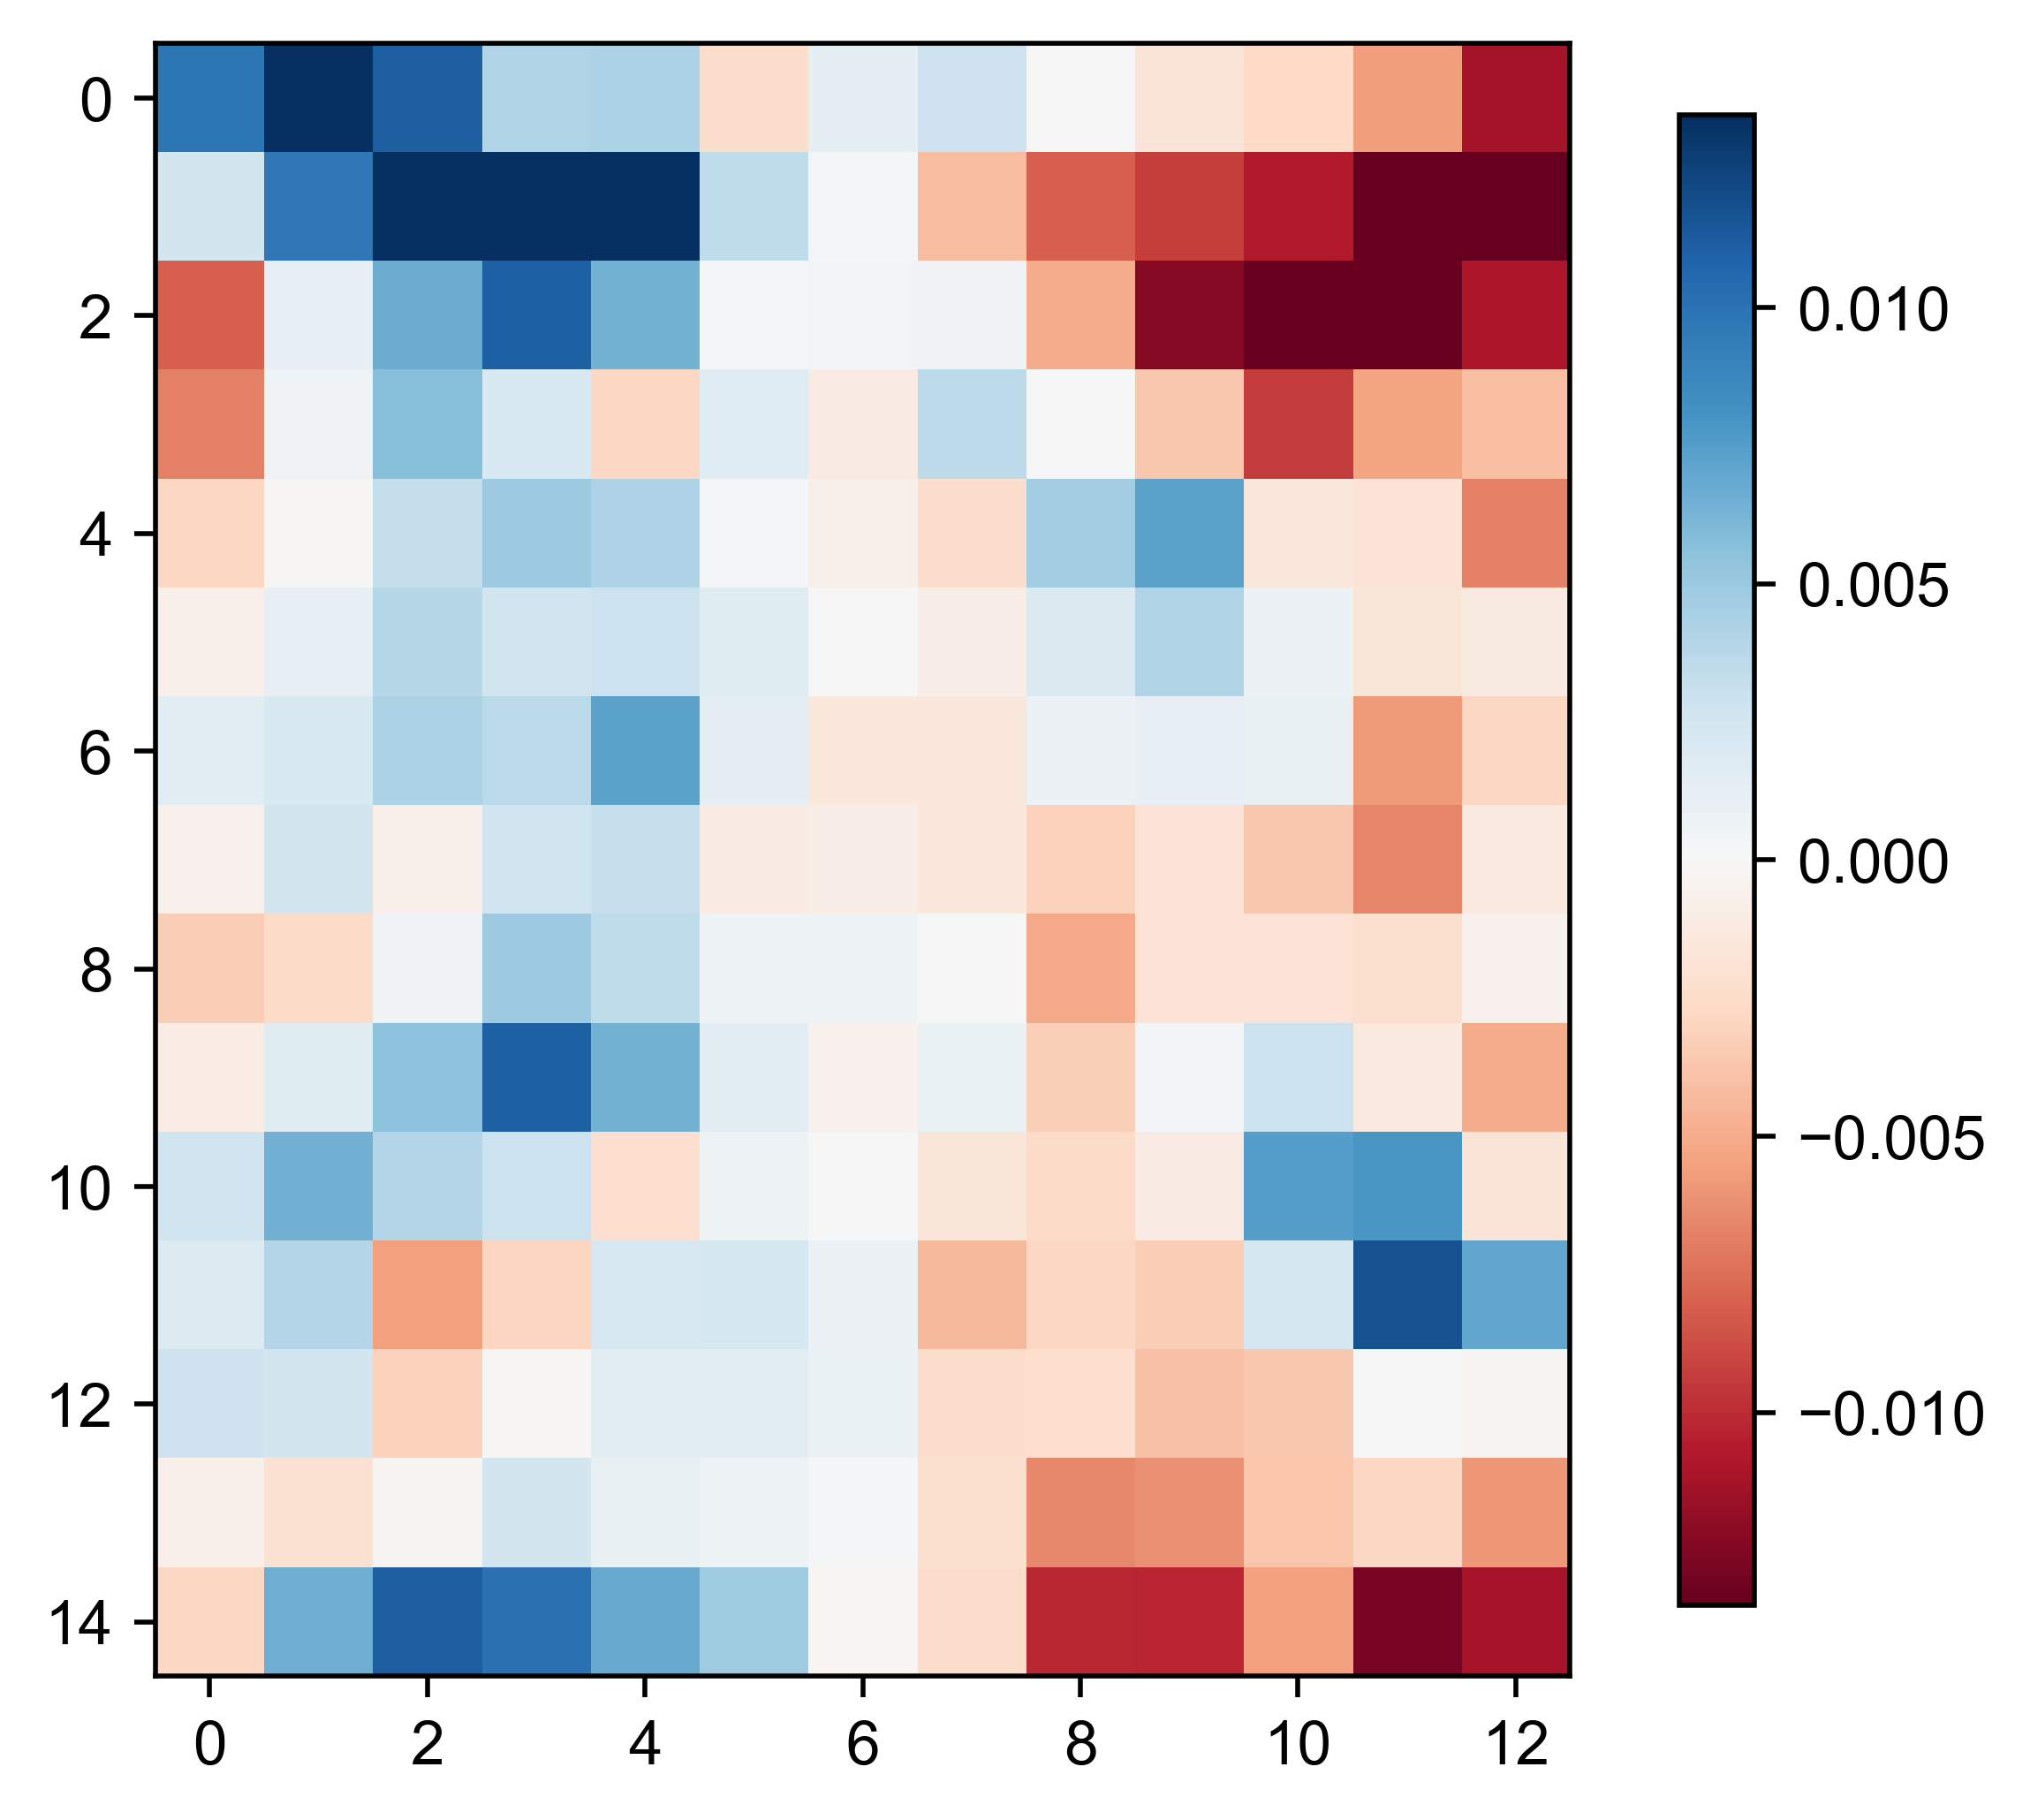

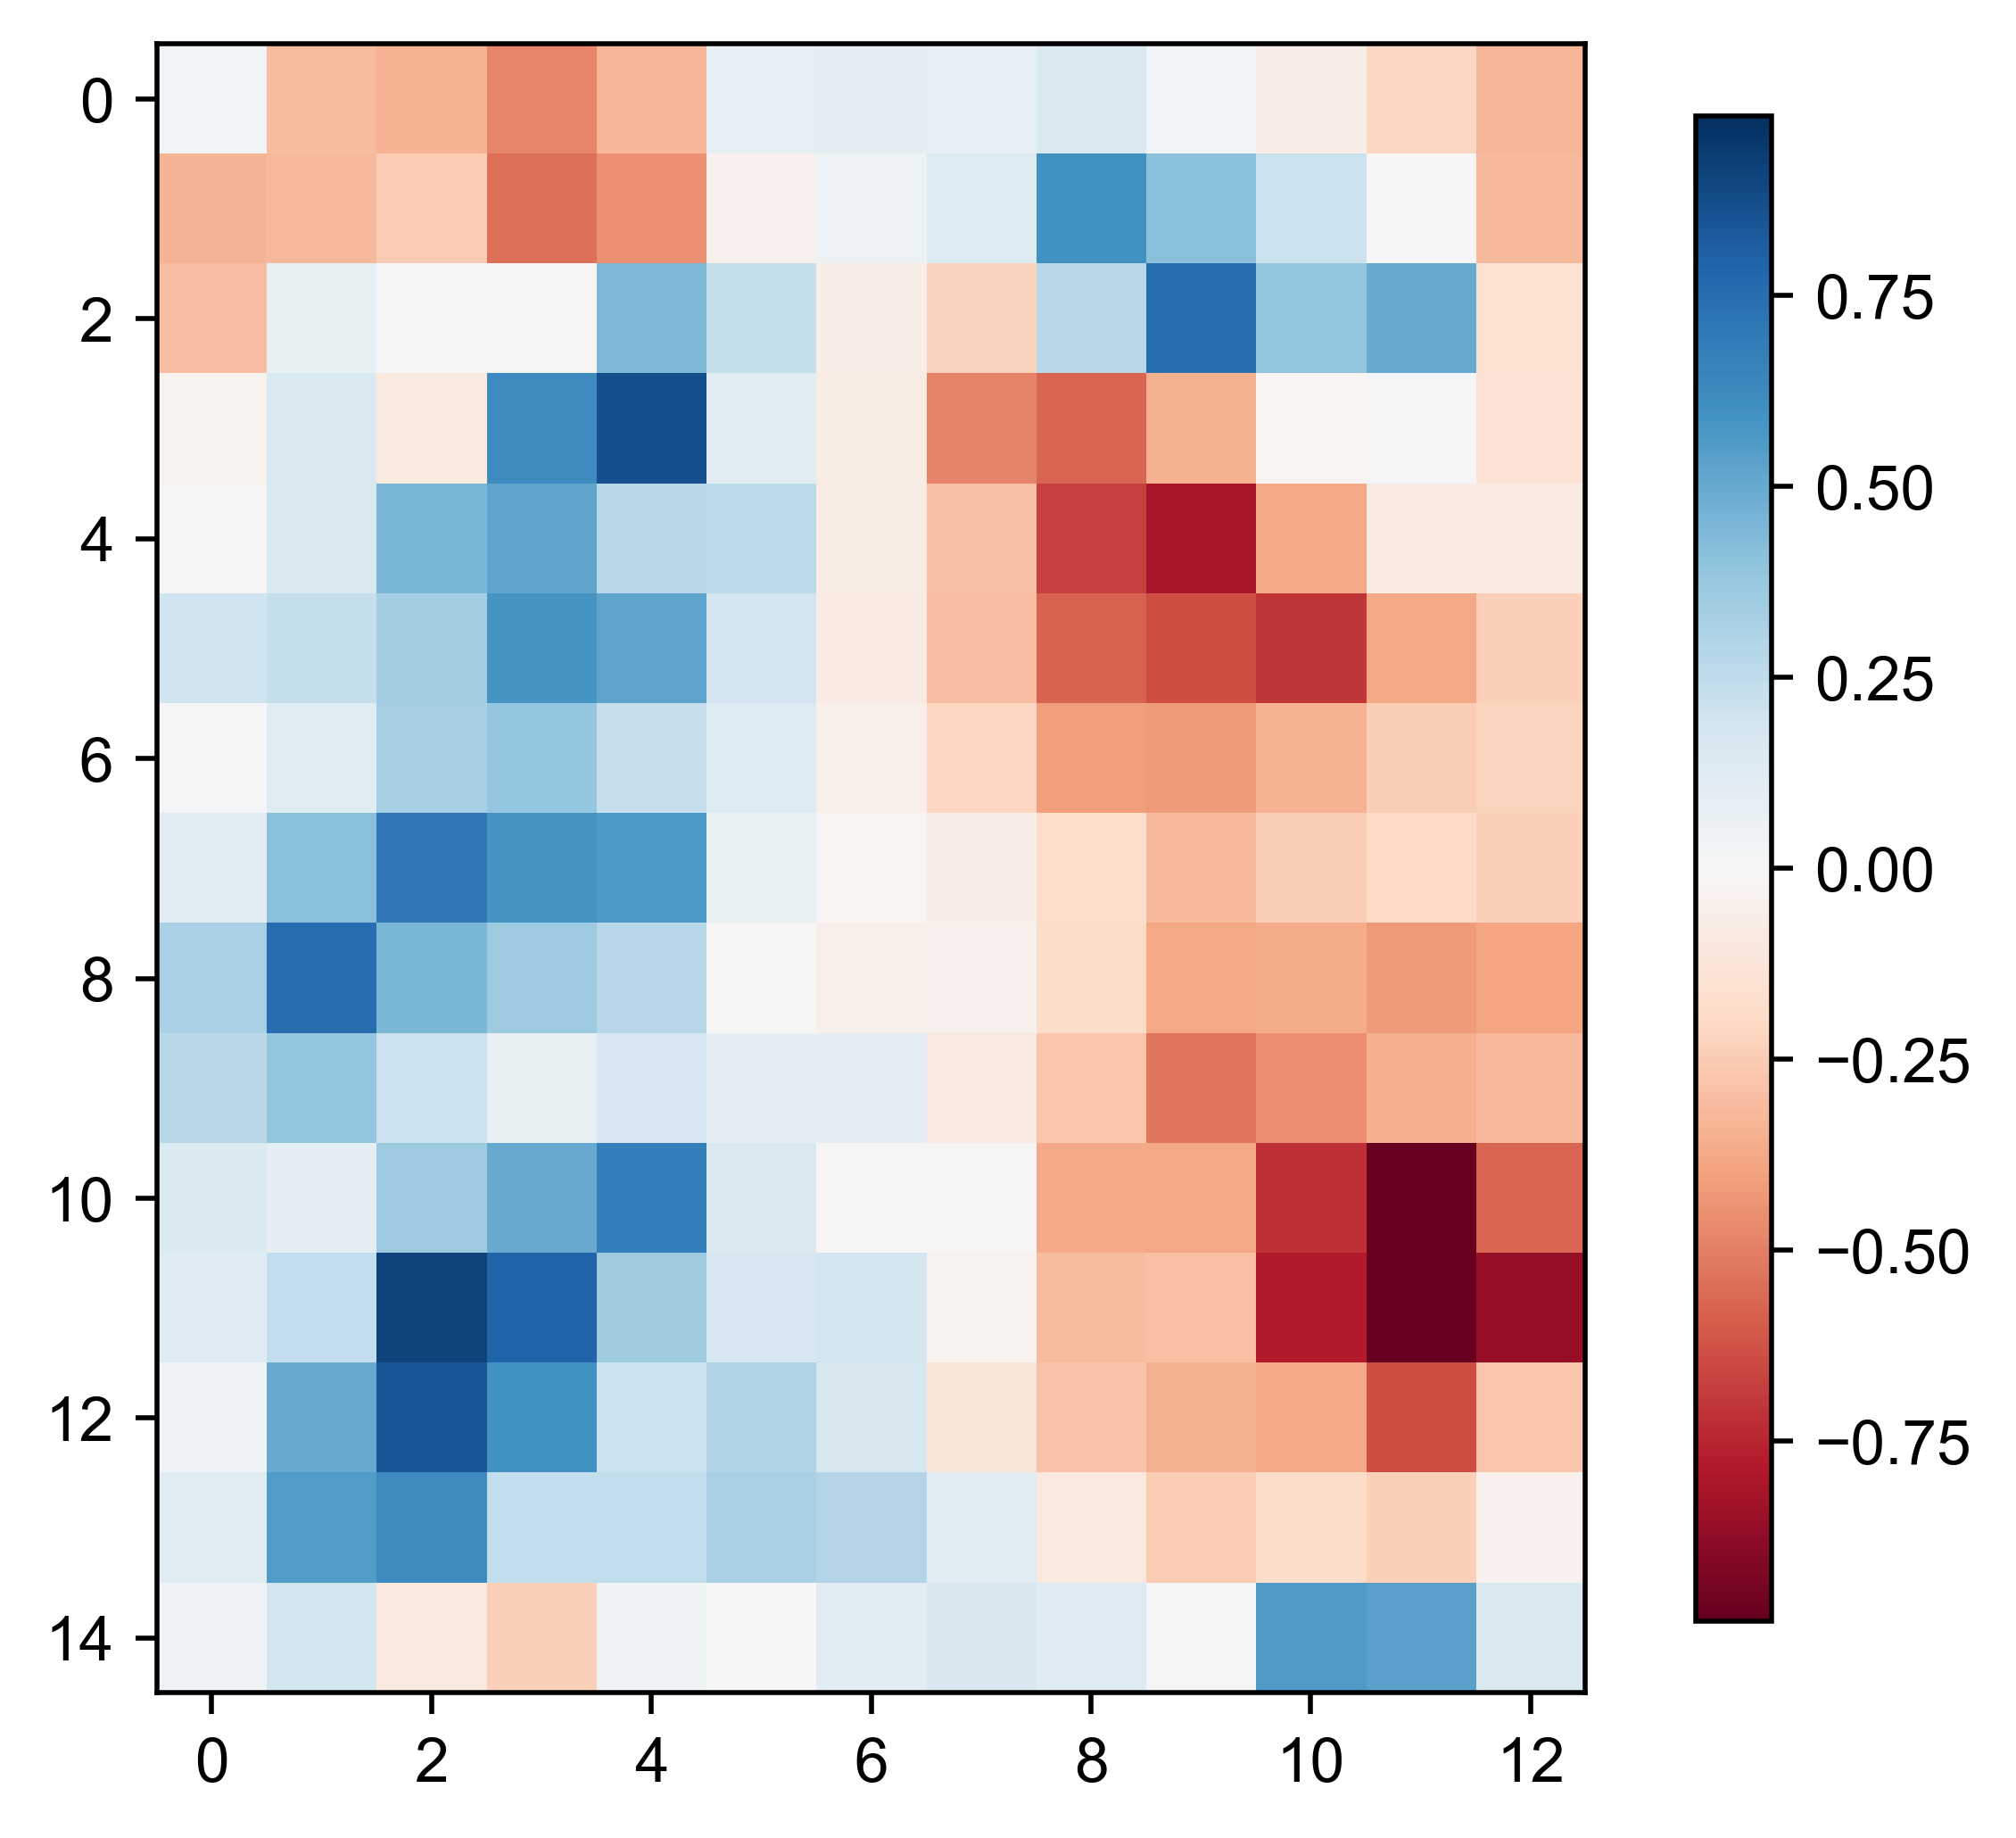

In [61]:
for strain_map in final_strain_maps:
    plt.figure(dpi=500)
    val = np.max(np.abs(strain_map[:150,:]))*0.9
    plt.imshow(strain_map, cmap='RdBu', vmin=-val, vmax=val)
    # plt.axis('on')
    # plt.grid()
    plt.colorbar(fraction=0.034)
    plt.show()

In [ ]:
# Save the data in .mat format
save_mat_data(exx_data, 
              save_dir + '/exx_rippleData.mat', 
              'exx_rippleData')
save_mat_data(eyy_data, 
              save_dir + '/eyy_rippleData.mat', 
              'eyy_rippleData')
save_mat_data(exy_data, 
              save_dir + '/exy_rippleData.mat', 
              'exy_rippleData')
save_mat_data(erot_data, 
              save_dir + '/erot_rippleData.mat', 
              'erot_rippleData')

### 4.3. Strain Correction

The axis rotation that maximizes strain correction sum over the x-direction is 1.8036072144288577°


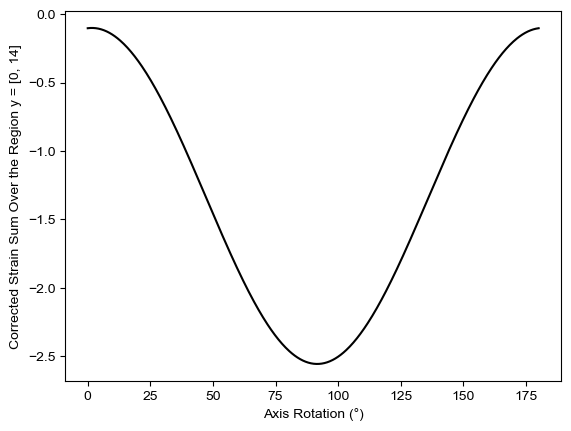

In [57]:
# Find the correction angle
angles = np.linspace(0,180,500)
sums = np.zeros(500)

y_upper, y_lower = 0, 14 

for i in range(500):

    exx_corr, eyy_corr, exy_corr = correct_strain(final_strain_maps[0,], final_strain_maps[1,], final_strain_maps[2,], 
                                              phi= np.radians(angles[i]) + ripple_tilt_axis, 
                                              theta=ripple_tilt)
    sums[i] = np.sum(exx_corr[y_upper:y_lower, :])

rot = angles[np.argmax(sums)]
print(f"The axis rotation that maximizes strain correction sum over the x-direction is {rot}°")

plt.plot(angles, sums, c='black')
plt.ylabel(f"Corrected Strain Sum Over the Region y = [{y_upper}, {y_lower}]")
plt.xlabel("Axis Rotation (°)")
plt.show()

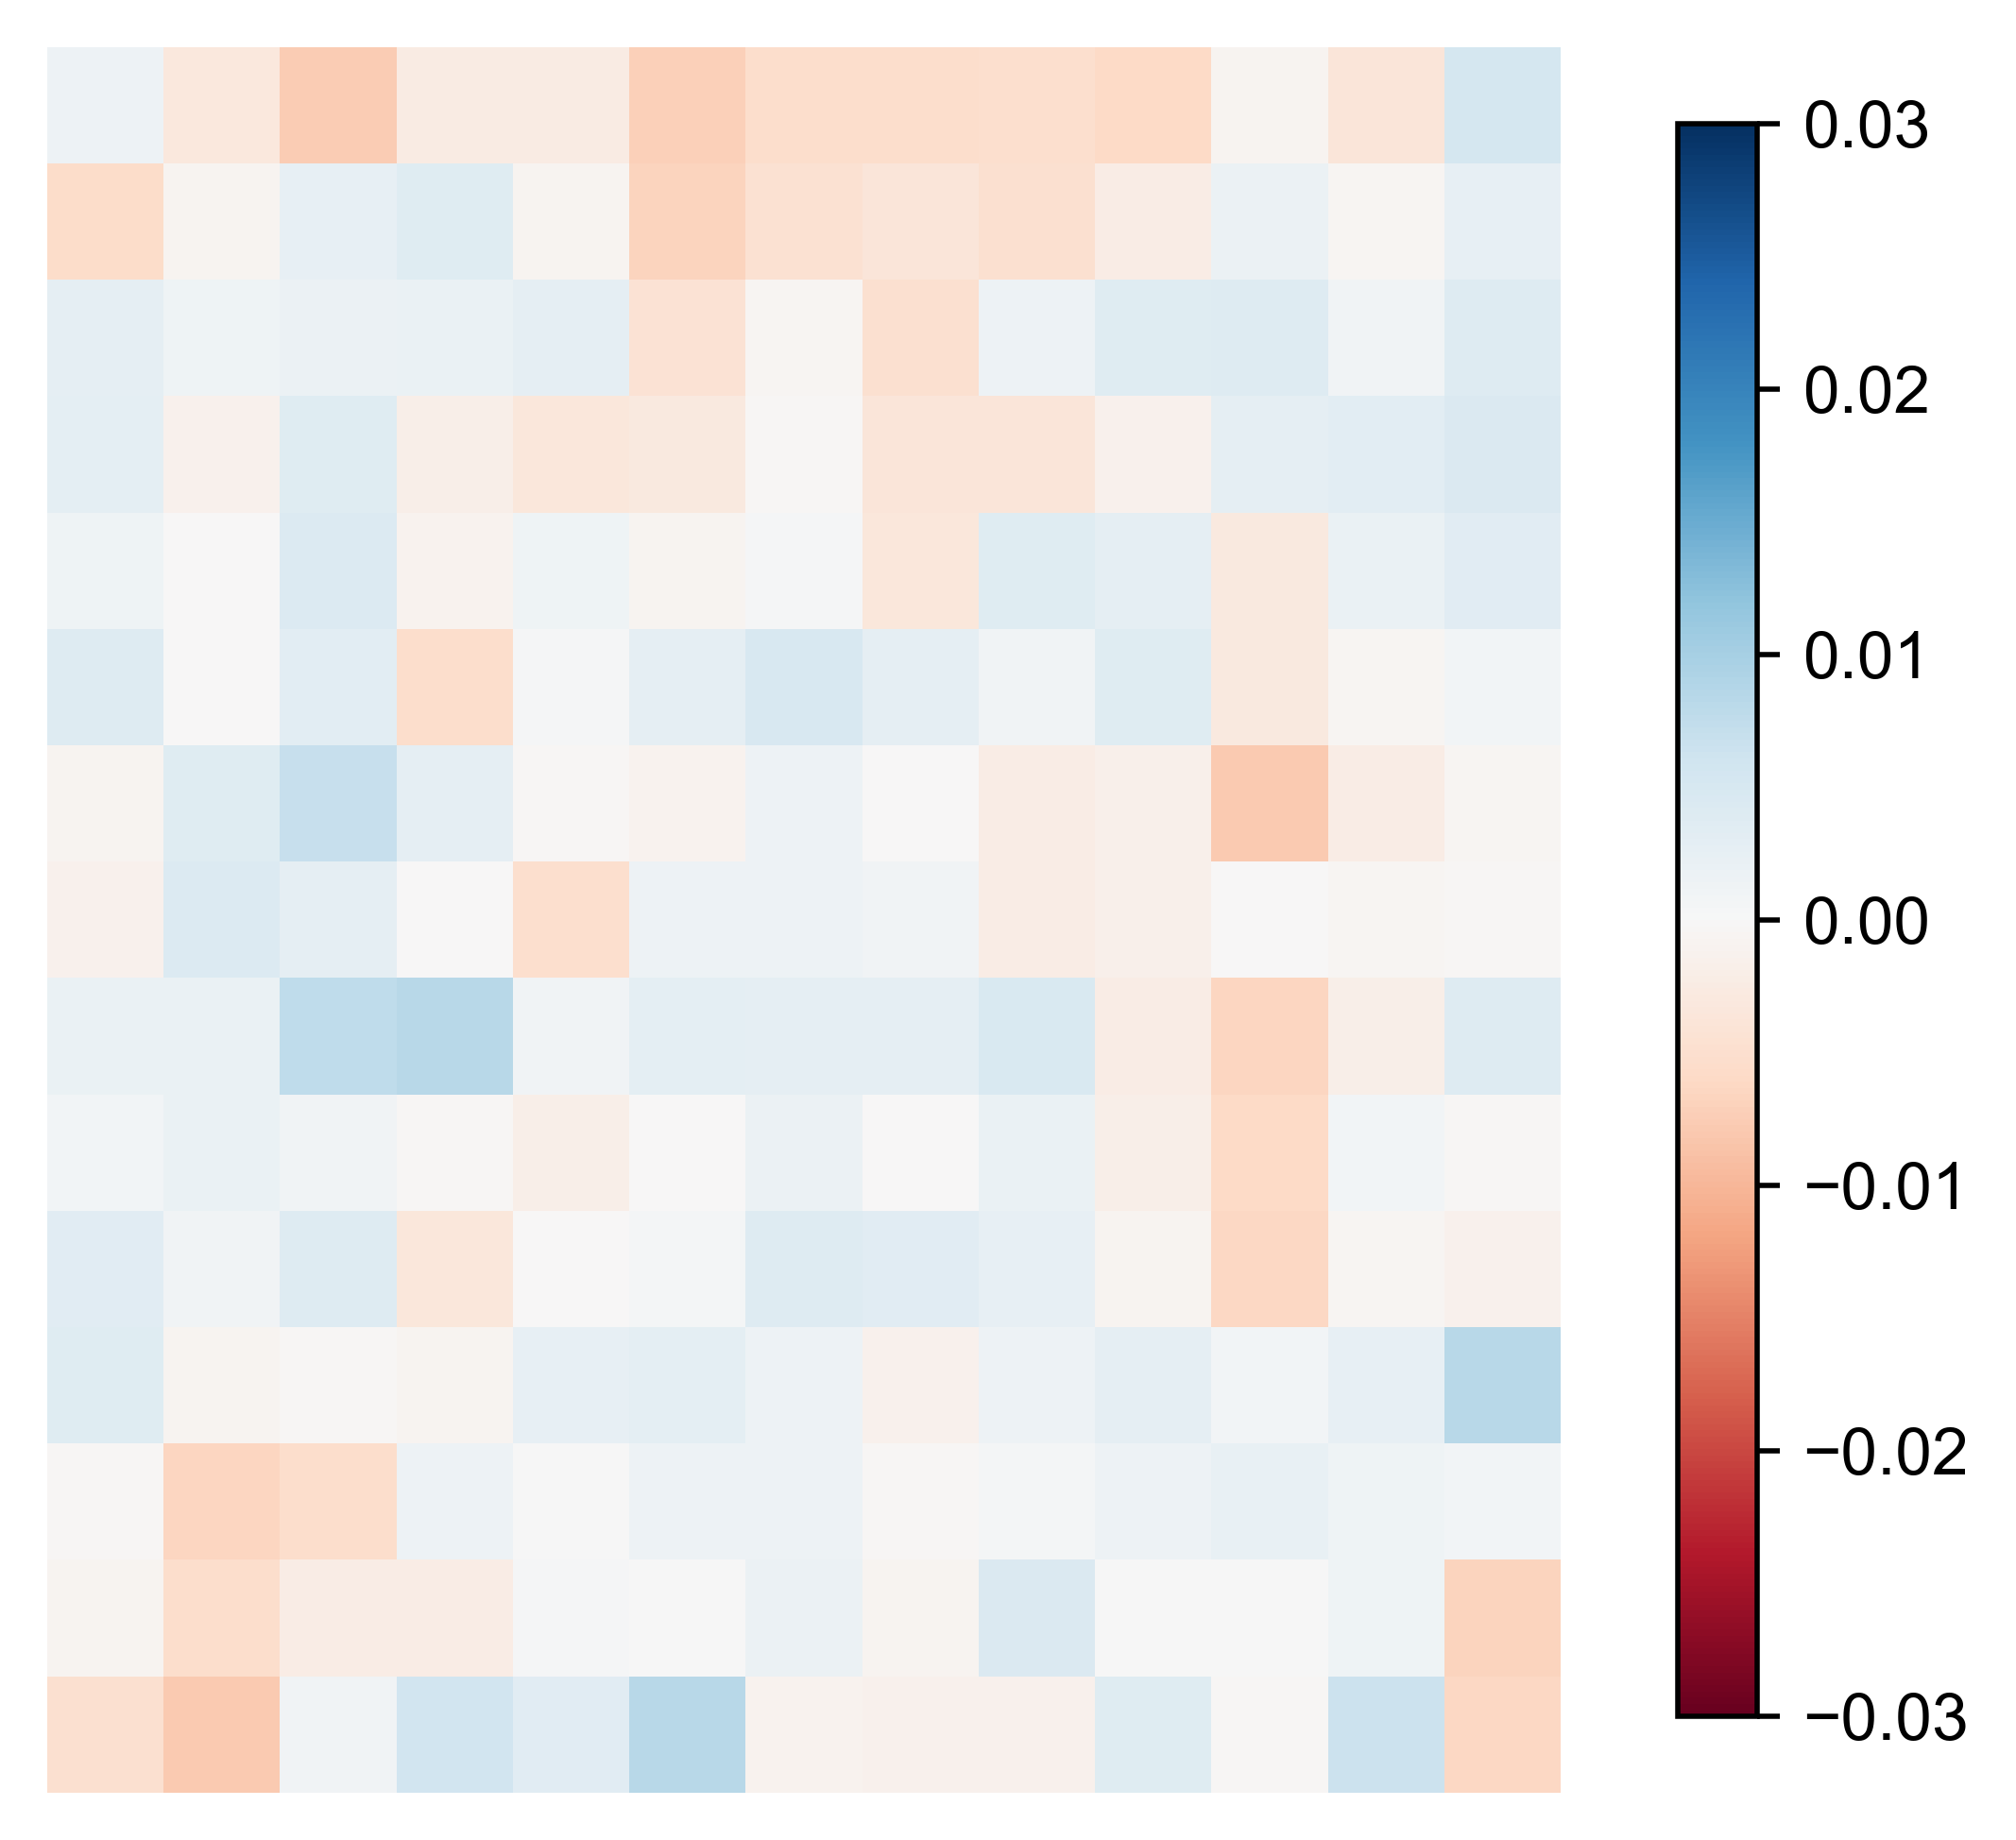

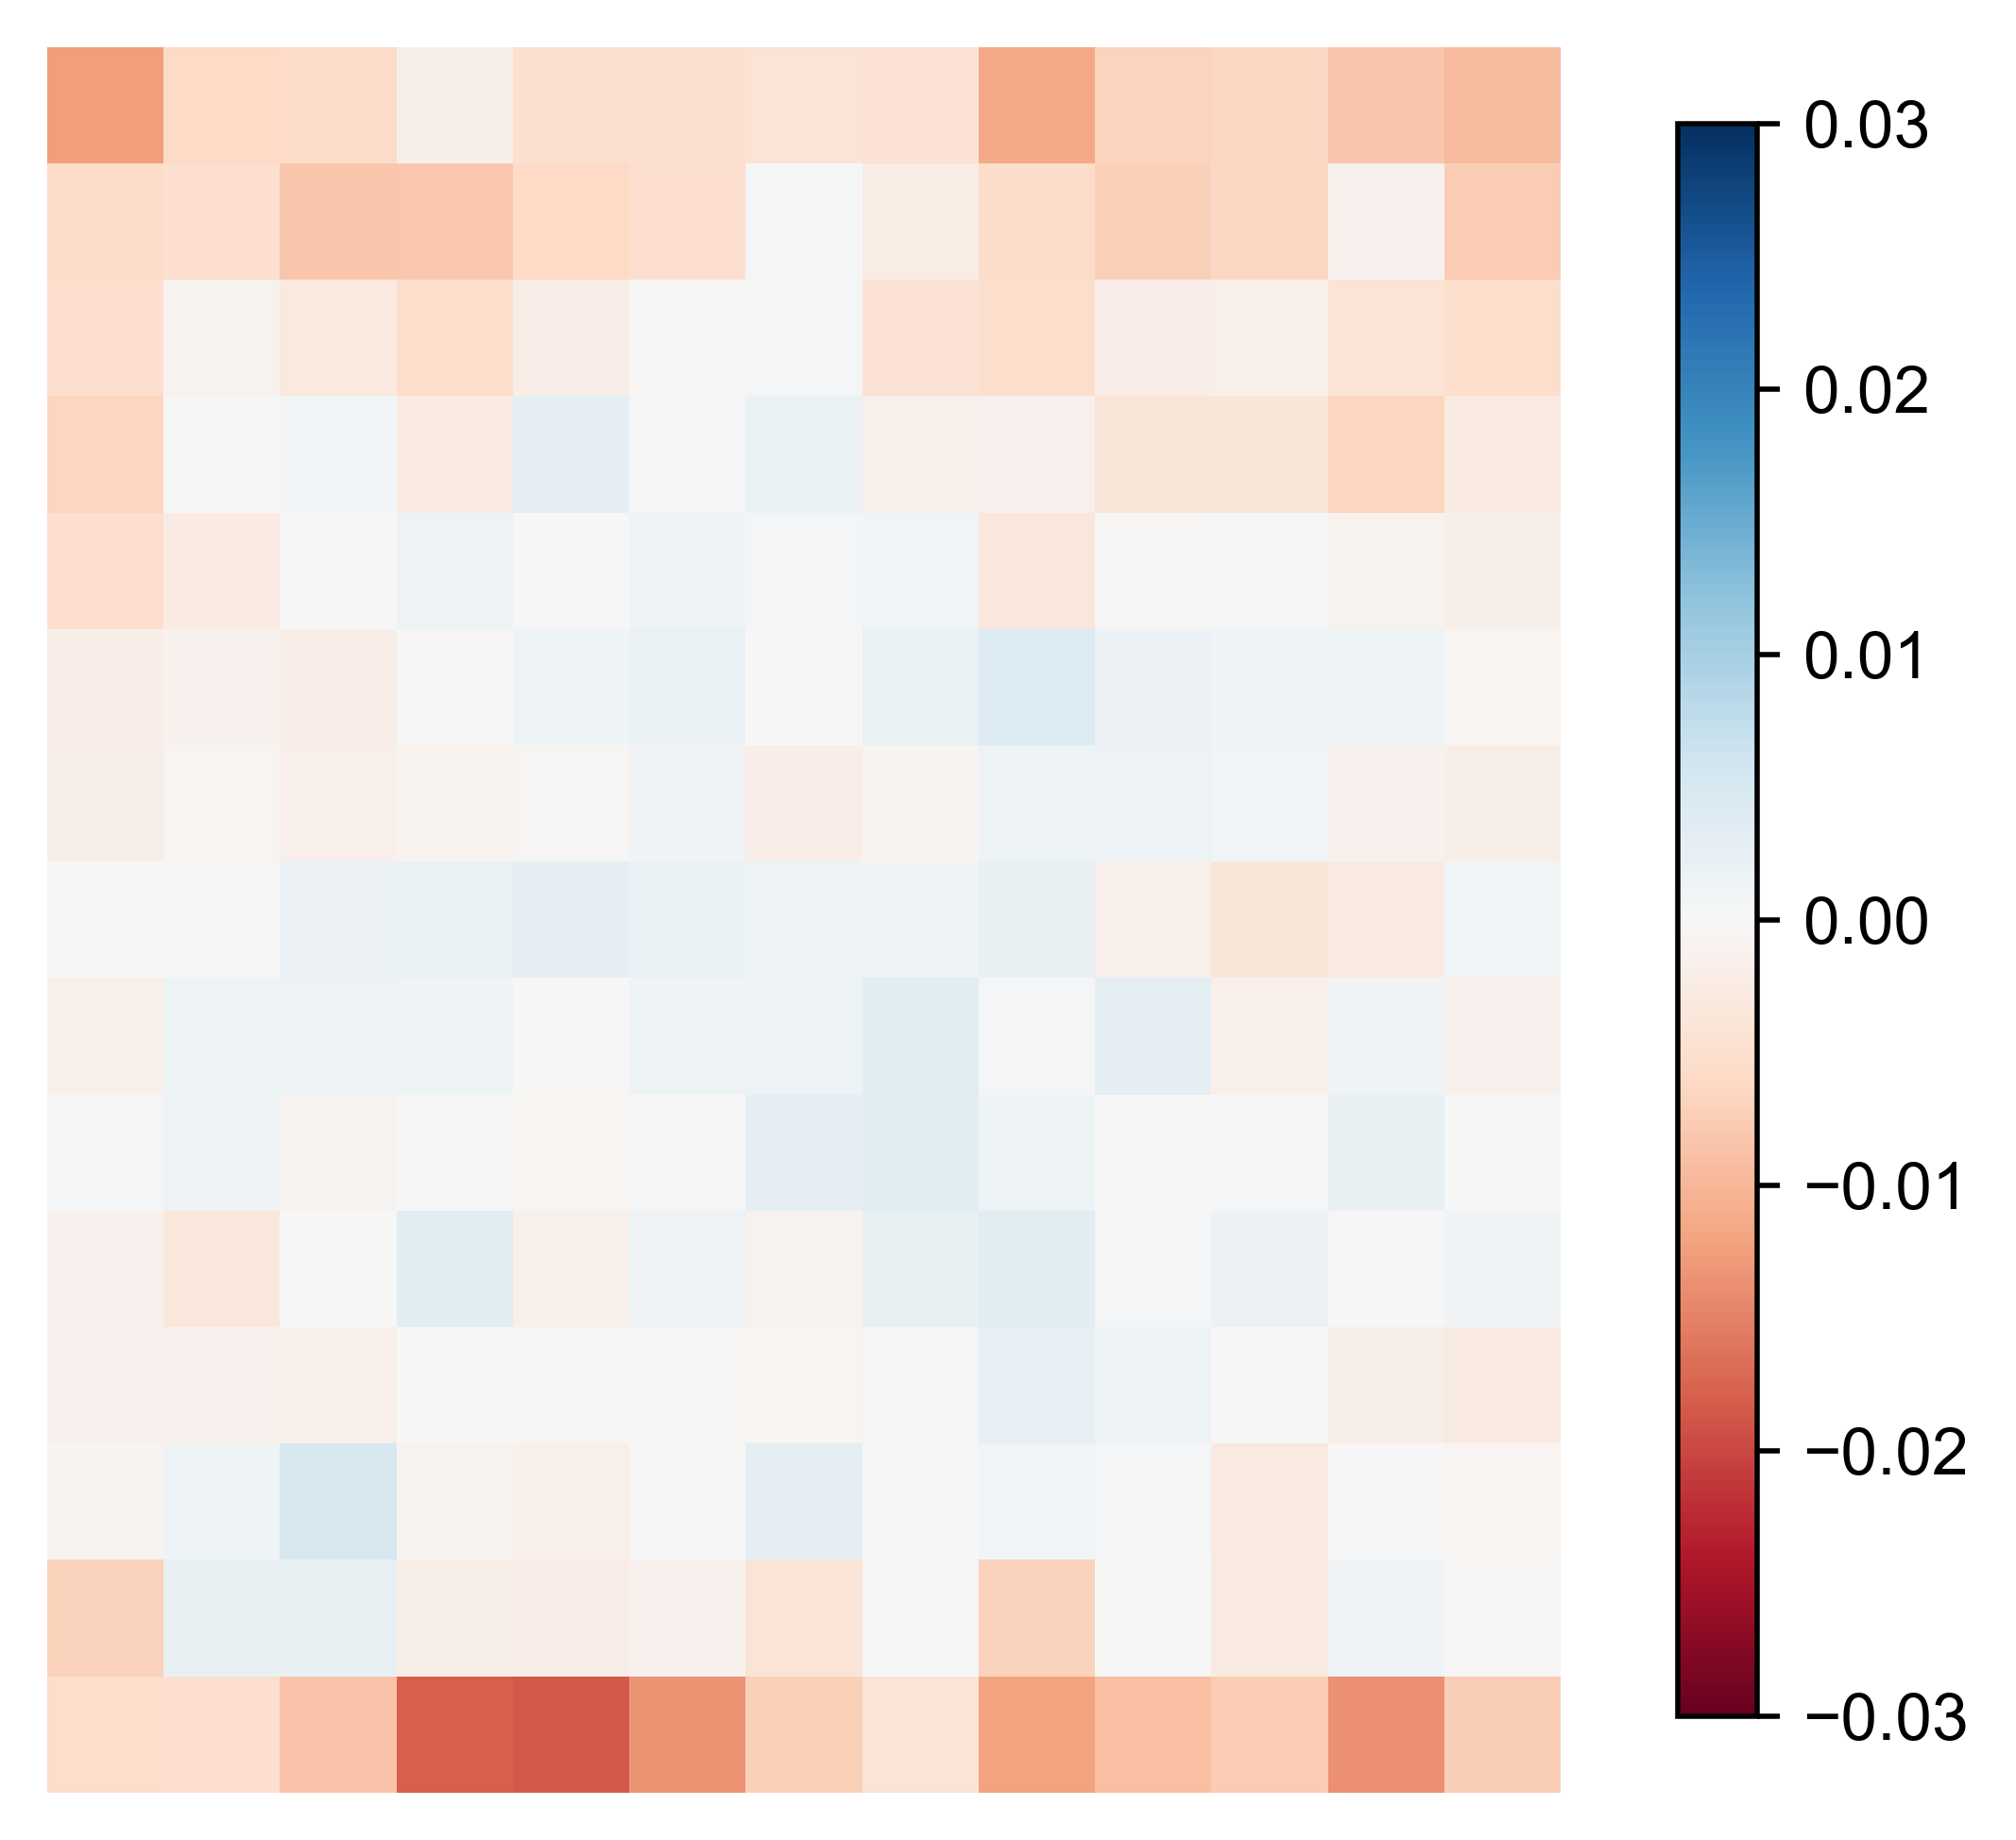

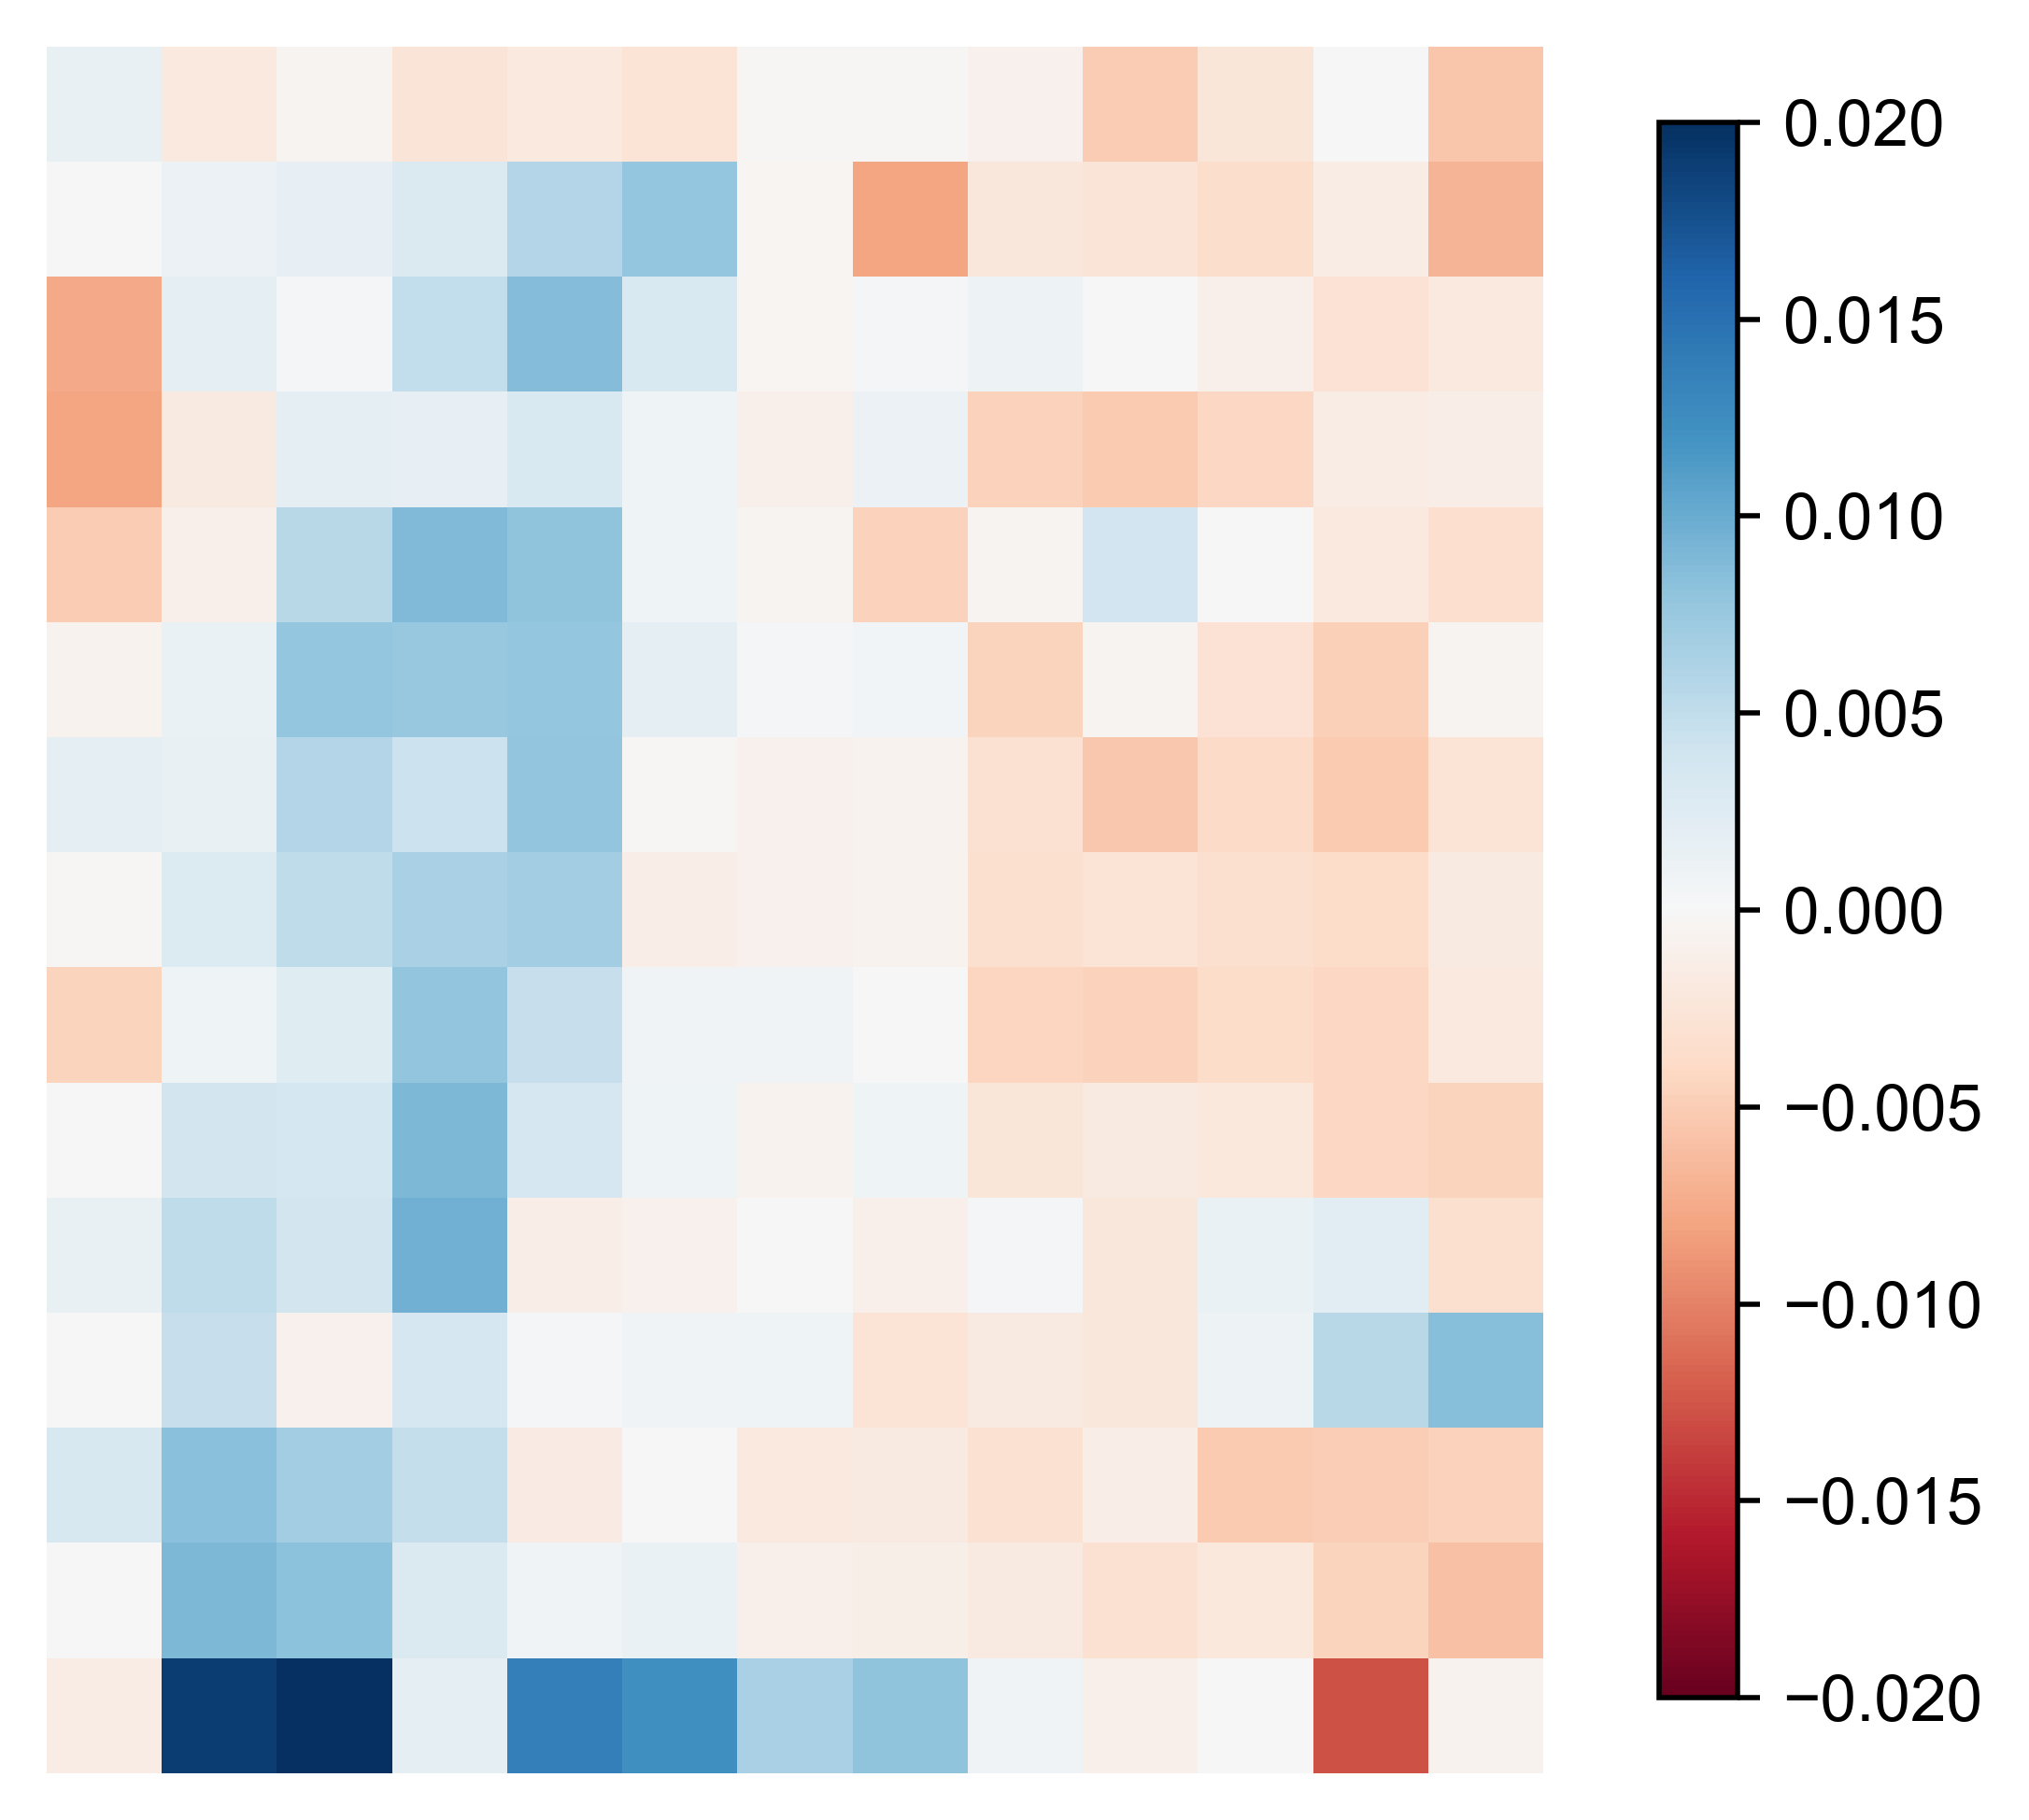

In [63]:
exx_corr, eyy_corr, exy_corr = correct_strain(final_strain_maps[0,], final_strain_maps[1,], final_strain_maps[2,], 
                                              phi=np.radians(rot) + ripple_tilt_axis, 
                                              theta=tilts[:,:,1])

val = 0.03
plt.figure(dpi=500)
plt.imshow(exx_corr, cmap='RdBu', vmin=-val, vmax=val)
plt.axis('off')
plt.colorbar(fraction=0.034)
plt.show()

val = 0.03
plt.figure(dpi=500)
plt.imshow(eyy_corr, cmap='RdBu', vmin=-val, vmax=val)
plt.axis('off')
plt.colorbar(fraction=0.034)
plt.show()

val = 0.02
plt.figure(dpi=500)
plt.imshow(exy_corr, cmap='RdBu', vmin=-val, vmax=val)
plt.axis('off')
plt.colorbar(fraction=0.034)
plt.show()

In [684]:
# Save the correction data in .mat format
save_mat_data(exx_corr, 
              save_dir + '/exx_rippleData_corrected.mat', 
              'exx_rippleData_corrected')
save_mat_data(eyy_corr, 
              save_dir + '/eyy_rippleData_corrected.mat', 
              'eyy_rippleData_corrected')
save_mat_data(exy_corr, 
              save_dir + '/exy_rippleData_corrected.mat', 
              'exy_rippleData_corrected')